# Table of Content

> [1.Business problem Statment](#BPS)

> [2.Data Dictionary](#DD)
>> [2.1 Time Series Dataset](#TS)

>> [2.2 Qualitative Dataset](#QS)

> [3.Data Loading](#DL)

> [4.Time Series dataset](#TSD)
>> [4.1 Data Overview ](#DO1)

>> [4.2 Data Enrichment](#DE1)

> [5.Store Features Dataset](#SFD)

>> [5.1 Data Overview ](#DO2)

> [6.Merged Dataset](#MD)

>> [6.1 Data Overview ](#DO3)

>> [6.2 Label Encoding ](#LE)

> [7.Pre-modelling](#PMO)

>> [7.1 Data Pre-processing](#DAP)

>> [7.2 Time Series Decomposition](#TSD)

>> [7.3 Stationarity Check](#SC)

>> [7.4 Data Clustering](#DC)

> [8. Model Development](#MD)

>> [8.1 XGB Model](#XG)

>> [8.2 Prophet Model](#PM)

>>> [8.2.1 Cluster-1](#C1)

>>> [8.2.2 Cluster-2](#C2)

>>> [8.2.3 Cluster-3](#C3)

>>> [8.2.4 Cluster-4](#C4)


#<a name = "BPS"> Business problem Statement</a>

A retail convenience chain, Maverik, fuels adventures in more than 380 locations across 12 western states. Maverik is known for premium BonFire food, diesel and unleaded fuel, and in-store merchandise. The company is on an expansion spree and as part of its growth, it recently acquired “ Kum & Go” nearly doubling its store count.

**Problem statement**  
The company is planning to open 30 new stores yearly in a new market, and it needs to forecast daily sales for the new store. This is crucial for financial planning and return on investment (ROI) assessment for these new stores. The challenge lies in predicting the first-year sales for these newly acquired stores accurately.

We have limited amount of data; therefore, we will be using currently available historical dataset to address analytical problems we will be addressing in this project are *identifying trends and patterns in sales data*, *understanding the relationship between sales and other factors*, and *identifying outliers and anomalies*. By addressing these analytical problems, we will be able to build a sales forecasting model.

**Solution**  
We will develop a sales forecasting model that can accurately predict daily sales for the new store. We will be using a variety of forecasting methods, such as time series analysis, regression analysis, causal analysis, and machine learning. The model will be evaluated by comparing its prediction to actual sales data from a holdout dataset. The model performance will be evaluated using industry-standard metrics such as Forecast Accuracy Metrics (e.g. MAE, MAPE, RMSE) and its ability to update forecasts dynamically in response to new data.

This sales forecasting model will help the company to make informed decisions about staffing, inventory, and marketing for the new stores. This can help the company to maximize its profits and minimize its losses while maintaining customer satisfaction.

#<a name = "DD">Data Dictionary</a>

##<a name = "TS"> Time Series Dataset </a>

**capital_projects.soft_opening_date** : The date this store opened

**calendar.calendar_day_date** : date

**calendar.fiscal_week_id_for_year** : Fiscal Week Number

**calendar.day_of_week** : Day of the week

**calendar_information.holiday** : Holiday information for that date

**calendar_information.type_of_day** : Day type

**daily_yoy_ndt.total_inside_sales** : Inside sales, everything that isn't made at the store

**daily_yoy_ndt.total_food_service** : Food service sales, everything that is made at the store

**diesel** : Diesel gallons sold

**unleaded** : all non-diesel(unleaded) gallons sold

**site_id_msba** : Unique site key


##<a name = "QS"> Qualitative Dataset </a>

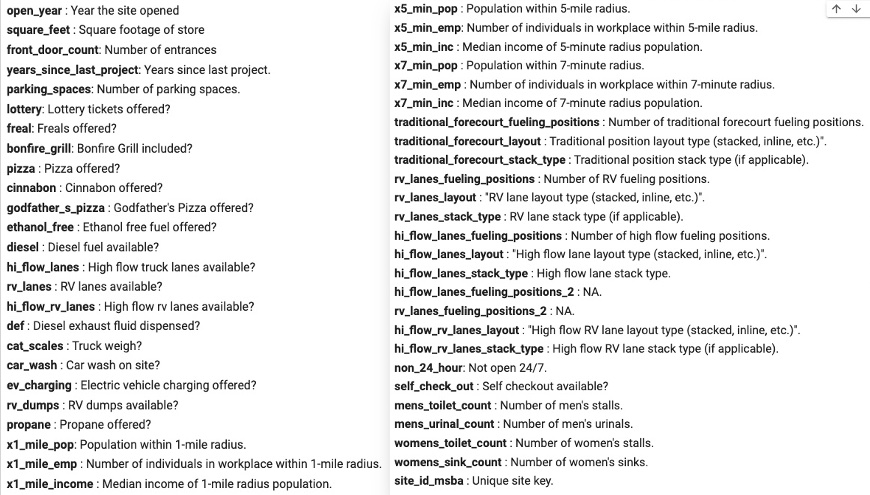

Based on the information given to us thus far, key columns for later merge train & test tables are going to be:

timeseries --> site_id_msba  
qualitative_data --> site_id_msba



*   Is there seasonality in gasoline sales?
*   How do sales differ by day?
*   What's the scope of NAs? Should we consider dropping columns based on NAs and variance?
*   What are the trends in sales over time?
* What factors influence the variation in sales across the months?
* Are there any trends in the sales data over time?
* How do the sales of the different products compare to each other?
* What are the key drivers of sales for each category?





#<a name = "DL"> Data Loading</a>

Loading our datasets and adding all necessary packages for the project.

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from itertools import combinations
from scipy.optimize import fminbound
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('prophet').propagate = False
logging.getLogger('cmdstanpy').propagate = False
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [ ]:
#Loading and renaming datasets for easy use. Qualitative is named as store_features
timeseries = pd.read_csv('/content/gdrive/MyDrive/Final Capstone - MSBA/Maverik/time_series_data_msba.csv')
store_features = pd.read_csv('/content/gdrive/MyDrive/Final Capstone - MSBA/Maverik/qualitative_data_msba.csv')

#<a name = "TSD"> Time series Dataset </a>

##<a name = "DO1"> Data Overview </a>

In [ ]:
# Displays information about the DataFrame
timeseries.info()

#Top 5 Rows of Dataset
display(timeseries.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13908 entries, 0 to 13907
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          13908 non-null  int64  
 1   capital_projects.soft_opening_date  13908 non-null  object 
 2   calendar.calendar_day_date          13908 non-null  object 
 3   calendar.fiscal_week_id_for_year    13908 non-null  int64  
 4   calendar.day_of_week                13908 non-null  object 
 5   calendar_information.holiday        13908 non-null  object 
 6   calendar_information.type_of_day    13908 non-null  object 
 7   daily_yoy_ndt.total_inside_sales    13908 non-null  float64
 8   daily_yoy_ndt.total_food_service    13908 non-null  float64
 9   diesel                              13908 non-null  float64
 10  unleaded                            13908 non-null  float64
 11  site_id_msba                        13908

,Unnamed: 0,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba
0,1,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535
1,2,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535
2,3,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535
3,4,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535
4,5,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535


Starting position of timeseries dataset -- 12 columns, 13908 rows. dtypes: float64(4), int64(3), object(5). There seems to be redundancy in data index with "Unnamed" column; therefore, this is being deleted below.

In [ ]:
timeseries = timeseries.drop(timeseries.columns[0], axis = 1)

#Dataset overview after dropping unnamed column.
timeseries.head()

,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba
0,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535
1,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535
2,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535
3,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535
4,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535


In [ ]:
timeseries.dtypes

capital_projects.soft_opening_date     object
calendar.calendar_day_date             object
calendar.fiscal_week_id_for_year        int64
calendar.day_of_week                   object
calendar_information.holiday           object
calendar_information.type_of_day       object
daily_yoy_ndt.total_inside_sales      float64
daily_yoy_ndt.total_food_service      float64
diesel                                float64
unleaded                              float64
site_id_msba                            int64
dtype: object

**Which features are categorical?**  
These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based. Among other things this helps us select the appropriate plots for visualization.



Categorical feature :  5  
['capital_projects.soft_opening_date', 'calendar.calendar_day_date', 'calendar.day_of_week', 'calendar_information.holiday', 'calendar_information.type_of_day']

**Which features are numerical?**  
These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based. Among other things this helps us select the appropriate plots for visualization.

Numerical feature :  6  
Discrete feature :  0  
Continous feature :  6  
['calendar.fiscal_week_id_for_year', 'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel', 'unleaded', 'site_id_msba']

##<a name = "DE1"> Data Enrichment </a>

In [ ]:
timeseries['capital_projects.soft_opening_date'] = pd.to_datetime(timeseries['capital_projects.soft_opening_date'])
timeseries['calendar.calendar_day_date'] = pd.to_datetime(timeseries['calendar.calendar_day_date'])

In [ ]:
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13908 entries, 0 to 13907
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   capital_projects.soft_opening_date  13908 non-null  datetime64[ns]
 1   calendar.calendar_day_date          13908 non-null  datetime64[ns]
 2   calendar.fiscal_week_id_for_year    13908 non-null  int64         
 3   calendar.day_of_week                13908 non-null  object        
 4   calendar_information.holiday        13908 non-null  object        
 5   calendar_information.type_of_day    13908 non-null  object        
 6   daily_yoy_ndt.total_inside_sales    13908 non-null  float64       
 7   daily_yoy_ndt.total_food_service    13908 non-null  float64       
 8   diesel                              13908 non-null  float64       
 9   unleaded                            13908 non-null  float64       
 10  site_id_msba          

These lines of code convert the 'capital_projects.soft_opening_date' and 'calendar.calendar_day_date' columns from their current data type to datetime data type . This conversion allows for more effective handling and analysis of date-related data.

In [ ]:
timeseries= timeseries.set_index('calendar.calendar_day_date')

This line of code sets the 'calendar.calendar_day_date' column as the "index" of the DataFrame 'time_series'. This means that the date column is used as the row labels for the DataFrame, which can be helpful for time series analysis and accessing data by date.

In [ ]:
timeseries['Year'] = timeseries.index.year
timeseries['Month'] = timeseries.index.month
timeseries['Day'] = timeseries.index.day
timeseries['DayOfYear'] = timeseries.index.dayofyear

These lines of code create new columns in the 'time_series' DataFrame: 'Year', 'Month', 'Day', and 'DayOfYear'.

- 'Year' column stores the year component of the date.
- 'Month' column stores the month component of the date.
- 'Day' column stores the day component of the date.
- 'DayOfYear' column stores the day of the year for each date.

In [ ]:
#Creating function to calculate season
def map_month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

#Adds "season" column to the timeseries dataset
timeseries['season'] = timeseries.index.month.map(map_month_to_season)

This code defines a function `map_month_to_season` that takes a month (numeric) as input and returns a corresponding season as a string.  Seasons are categorized as 'Winter' (December, January, February), 'Spring' (March, April, May), 'Summer' (June, July, August), and 'Fall' (September, October, November).

In [ ]:
timeseries.sort_index(inplace=True)

The code sorts the DataFrame 'time_series' based on its index in ascending order.  After executing this code, the 'time_series' DataFrame will be sorted based on its index, and the rows will be arranged in ascending order of the index values.

In [ ]:
#Overview of the dataset
timeseries.head()

,capital_projects.soft_opening_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba,Year,Month,Day,DayOfYear,season
calendar.calendar_day_date,,,,,,,,,,,,,,,
2021-01-12,2021-01-12,2,Tuesday,NONE,WEEKDAY,2036.2685,762.8530,1424.1850,1522.0030,21560,2021,1,12,12,Winter
2021-01-13,2021-01-12,2,Wednesday,NONE,WEEKDAY,2379.8880,1003.7930,1303.8445,1853.7715,21560,2021,1,13,13,Winter
2021-01-14,2021-01-12,2,Thursday,NONE,WEEKDAY,2435.8600,974.2250,1375.6785,2122.4070,21560,2021,1,14,14,Winter
2021-01-15,2021-01-12,3,Friday,NONE,WEEKDAY,2805.9780,911.0115,1334.9175,2267.9930,21560,2021,1,15,15,Winter
2021-01-16,2021-01-12,3,Saturday,NONE,WEEKEND,2314.7635,715.7535,831.1625,1819.6395,21560,2021,1,16,16,Winter


# <a name = "SFD"> Store Features Dataset </a>

##<a name = "DO2"> Data Overview</a>

In [ ]:
store_features.info()
display(store_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Unnamed: 0                               37 non-null     int64 
 1   open_year                                37 non-null     int64 
 2   square_feet                              37 non-null     int64 
 3   front_door_count                         37 non-null     int64 
 4   years_since_last_project                 37 non-null     int64 
 5   parking_spaces                           37 non-null     int64 
 6   lottery                                  37 non-null     object
 7   freal                                    37 non-null     object
 8   bonfire_grill                            37 non-null     object
 9   pizza                                    37 non-null     object
 10  cinnabon                                 37 non-null     object


,Unnamed: 0,open_year,square_feet,front_door_count,years_since_last_project,parking_spaces,lottery,freal,bonfire_grill,pizza,...,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
0,1,2021,5046,2,2,38,Yes,Yes,Yes,No,...,6,Stack,HF/RV,No,Yes,2,2,6,2,21560
1,2,2021,5046,2,2,39,No,Yes,Yes,Yes,...,4,Combo,HF/RV,No,Yes,5,5,10,4,21980
2,3,2021,5046,2,2,35,Yes,Yes,Yes,Yes,...,5,In-Line,None,No,Yes,3,2,4,1,22015
3,4,2021,5046,2,2,36,No,Yes,Yes,Yes,...,4,Combo,HF/RV,No,Yes,3,3,6,2,22085
4,5,2021,5046,2,2,25,Yes,Yes,Yes,No,...,0,NaN,NaN,No,Yes,0,0,0,0,22120


Starting position of store_features dataset -- 55columns, 37 rows. dtypes: int64(28), object(27).  

We removed the first column that was not assigned any name. It does contain only serial numbers and hence removed.

In [ ]:
from zmq.constants import NULL

# Replace 'None' with 'N/A' in the specified column
column_to_replace = ['traditional_forecourt_stack_type','rv_lanes_stack_type','hi_flow_rv_lanes_stack_type']
store_features[column_to_replace] = store_features[column_to_replace].replace('None',np.NaN)


In [ ]:
#dropping column
store_features.drop(columns='Unnamed: 0', inplace=True)
store_features.head()

,open_year,square_feet,front_door_count,years_since_last_project,parking_spaces,lottery,freal,bonfire_grill,pizza,cinnabon,...,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
0,2021,5046,2,2,38,Yes,Yes,Yes,No,No,...,6,Stack,HF/RV,No,Yes,2,2,6,2,21560
1,2021,5046,2,2,39,No,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,5,5,10,4,21980
2,2021,5046,2,2,35,Yes,Yes,Yes,Yes,No,...,5,In-Line,NaN,No,Yes,3,2,4,1,22015
3,2021,5046,2,2,36,No,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,3,3,6,2,22085
4,2021,5046,2,2,25,Yes,Yes,Yes,No,No,...,0,NaN,NaN,No,Yes,0,0,0,0,22120


In [ ]:
#descriptive analysis of the dataset
store_features.describe()


,open_year,square_feet,front_door_count,years_since_last_project,parking_spaces,x1_mile_pop,x1_mile_emp,x1_mile_income,x1_2_mile_pop,x1_2_mile_emp,...,traditional_forecourt_fueling_positions,rv_lanes_fueling_positions,hi_flow_lanes_fueling_positions,hi_flow_lanes_fueling_positions_2,rv_lanes_fueling_positions_2,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
count,37.000000,37.00000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,2021.324324,4970.27027,2.0,1.648649,37.405405,6703.567568,4757.648649,53300.378378,1833.108108,1514.135135,...,14.270270,2.513514,3.324324,3.324324,2.513514,2.378378,2.351351,4.648649,1.702703,23040.405405
std,0.474579,575.93121,0.0,0.483978,5.918237,5694.011350,4697.168291,24333.027254,1915.140476,2489.423094,...,3.948619,2.049683,2.925501,2.925501,2.049683,0.923500,0.856875,1.751447,0.740303,730.069801
min,2021.000000,2933.00000,2.0,1.000000,23.000000,0.000000,56.000000,0.000000,0.000000,31.000000,...,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21560.000000
25%,2021.000000,5046.00000,2.0,1.000000,34.000000,1984.000000,1771.000000,39538.000000,262.000000,386.000000,...,12.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,1.000000,22540.000000
50%,2021.000000,5046.00000,2.0,2.000000,38.000000,5574.000000,3895.000000,46356.000000,1003.000000,1037.000000,...,12.000000,4.000000,5.000000,5.000000,4.000000,2.000000,2.000000,4.000000,2.000000,22890.000000
75%,2022.000000,5046.00000,2.0,2.000000,41.000000,11269.000000,6002.000000,73519.000000,2686.000000,1616.000000,...,16.000000,4.000000,5.000000,5.000000,4.000000,3.000000,3.000000,6.000000,2.000000,23555.000000
max,2022.000000,6134.00000,2.0,2.000000,49.000000,18692.000000,26077.000000,110957.000000,5923.000000,15403.000000,...,24.000000,6.000000,9.000000,9.000000,6.000000,5.000000,5.000000,10.000000,4.000000,24535.000000


This shows us descriptive stats for our numerical columns. Overall, all of our stores have 2 front doors. We will utilize this output as we move to the next step in analysis.
Also, it shows us unique values for our dataset which is useful for data cleaning and feature engineering as needed. This helps us understand the diversity of the data and identify any columns with a small number of unique values. We closely analyze categorical columns to ensure that we don't overlook any values before factorizing.

##<a name = "DC"> Data Cleaning</a>

In [ ]:
identical_columns = []
for col1 in store_features.columns:
    for col2 in store_features.columns:
        if col1 != col2 and store_features[col1].equals(store_features[col2]):
            identical_columns.append(col1)

In [ ]:
import copy
store_features_cleaned= copy.deepcopy(store_features)

In [ ]:
store_features_cleaned.sample(n=5)

,open_year,square_feet,front_door_count,years_since_last_project,parking_spaces,lottery,freal,bonfire_grill,pizza,cinnabon,...,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count,site_id_msba
21,2021,5046,2,2,41,Yes,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,3,3,6,2,23240
10,2021,5046,2,2,44,Yes,Yes,No,Yes,No,...,4,Combo,HF/RV,No,Yes,3,3,6,2,22575
13,2021,5046,2,2,46,Yes,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,3,3,5,2,22715
0,2021,5046,2,2,38,Yes,Yes,Yes,No,No,...,6,Stack,HF/RV,No,Yes,2,2,6,2,21560
14,2021,5046,2,2,34,No,Yes,Yes,Yes,No,...,4,Combo,HF/RV,No,Yes,2,2,4,1,22750


#<a name = "MD"> Merged Dataset </a>

##<a name = "DO3"> Data Overview</a>

In [ ]:
timeseries.reset_index(inplace=True)

In [ ]:
#Merge dataset
bonfire = timeseries.merge(store_features, on='site_id_msba', how='outer')

#Top 5 rows of data overview
bonfire.head()

,calendar.calendar_day_date,capital_projects.soft_opening_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel_x,unleaded,...,hi_flow_lanes_fueling_positions_2,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count
0,2021-01-12,2021-01-12,2,Tuesday,NONE,WEEKDAY,2036.2685,762.8530,1424.1850,1522.0030,...,4.0,6.0,Stack,HF/RV,No,Yes,2.0,2.0,6.0,2.0
1,2021-01-13,2021-01-12,2,Wednesday,NONE,WEEKDAY,2379.8880,1003.7930,1303.8445,1853.7715,...,4.0,6.0,Stack,HF/RV,No,Yes,2.0,2.0,6.0,2.0
2,2021-01-14,2021-01-12,2,Thursday,NONE,WEEKDAY,2435.8600,974.2250,1375.6785,2122.4070,...,4.0,6.0,Stack,HF/RV,No,Yes,2.0,2.0,6.0,2.0
3,2021-01-15,2021-01-12,3,Friday,NONE,WEEKDAY,2805.9780,911.0115,1334.9175,2267.9930,...,4.0,6.0,Stack,HF/RV,No,Yes,2.0,2.0,6.0,2.0
4,2021-01-16,2021-01-12,3,Saturday,NONE,WEEKEND,2314.7635,715.7535,831.1625,1819.6395,...,4.0,6.0,Stack,HF/RV,No,Yes,2.0,2.0,6.0,2.0


In [ ]:
bonfire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13908 entries, 0 to 13907
Data columns (total 69 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   calendar.calendar_day_date               13908 non-null  datetime64[ns]
 1   capital_projects.soft_opening_date       13908 non-null  datetime64[ns]
 2   calendar.fiscal_week_id_for_year         13908 non-null  int64         
 3   calendar.day_of_week                     13908 non-null  object        
 4   calendar_information.holiday             13908 non-null  object        
 5   calendar_information.type_of_day         13908 non-null  object        
 6   daily_yoy_ndt.total_inside_sales         13908 non-null  float64       
 7   daily_yoy_ndt.total_food_service         13908 non-null  float64       
 8   diesel_x                                 13908 non-null  float64       
 9   unleaded                               

##<a name = "LE"> Label Encoding </a>

In [ ]:
from sklearn.preprocessing import LabelEncoder

object_columns = bonfire.select_dtypes(include=['object']).columns.tolist()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to object columns
for col in object_columns:
    bonfire[col] = label_encoder.fit_transform(bonfire[col])



The Label Encoder transforms categorical variables into numerical values, preparing the data for identifying key contributors effectively.

In [ ]:
bonfire.head()

,calendar.calendar_day_date,capital_projects.soft_opening_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel_x,unleaded,...,hi_flow_lanes_fueling_positions_2,rv_lanes_fueling_positions_2,hi_flow_rv_lanes_layout,hi_flow_rv_lanes_stack_type,non_24_hour,self_check_out,mens_toilet_count,mens_urinal_count,womens_toilet_count,womens_sink_count
0,2021-01-12,2021-01-12,2,5,16,0,2036.2685,762.8530,1424.1850,1522.0030,...,4.0,6.0,2,0,0,0,2.0,2.0,6.0,2.0
1,2021-01-13,2021-01-12,2,6,16,0,2379.8880,1003.7930,1303.8445,1853.7715,...,4.0,6.0,2,0,0,0,2.0,2.0,6.0,2.0
2,2021-01-14,2021-01-12,2,4,16,0,2435.8600,974.2250,1375.6785,2122.4070,...,4.0,6.0,2,0,0,0,2.0,2.0,6.0,2.0
3,2021-01-15,2021-01-12,3,0,16,0,2805.9780,911.0115,1334.9175,2267.9930,...,4.0,6.0,2,0,0,0,2.0,2.0,6.0,2.0
4,2021-01-16,2021-01-12,3,2,16,1,2314.7635,715.7535,831.1625,1819.6395,...,4.0,6.0,2,0,0,0,2.0,2.0,6.0,2.0


In [ ]:
# bonfire.info()

### Feature importance

hi_flow_lanes_fueling_positions      0.317313
hi_flow_lanes_fueling_positions_2    0.317313
rv_lanes_layout                      0.316783
pizza                                0.314609
rv_lanes_fueling_positions           0.313007
Name: daily_yoy_ndt.total_inside_sales, dtype: float64


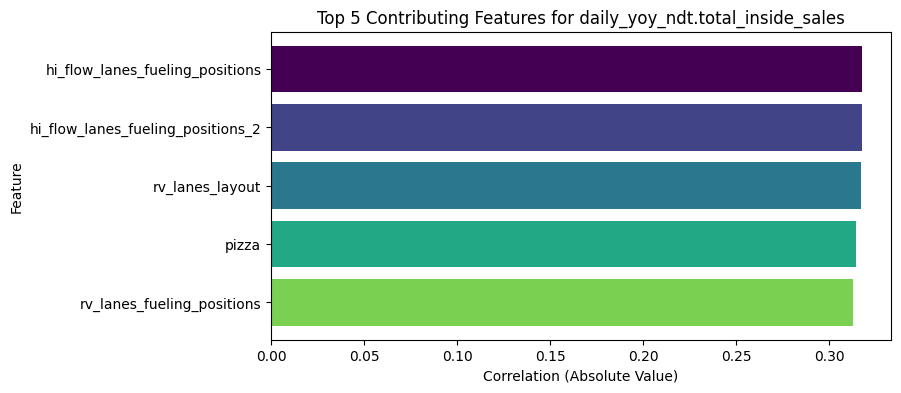

rv_lanes_stack_type                  0.509038
hi_flow_lanes_stack_type             0.509038
hi_flow_rv_lanes_stack_type          0.509038
hi_flow_lanes_fueling_positions      0.508713
hi_flow_lanes_fueling_positions_2    0.508713
Name: daily_yoy_ndt.total_food_service, dtype: float64


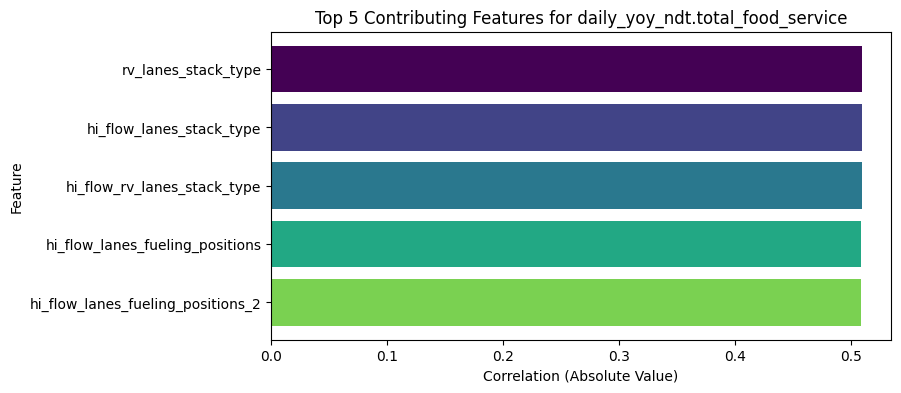

hi_flow_lanes_fueling_positions      0.641990
hi_flow_lanes_fueling_positions_2    0.641990
mens_urinal_count                    0.618443
mens_toilet_count                    0.564103
womens_sink_count                    0.553721
hi_flow_lanes_layout                 0.511342
Name: diesel_x, dtype: float64


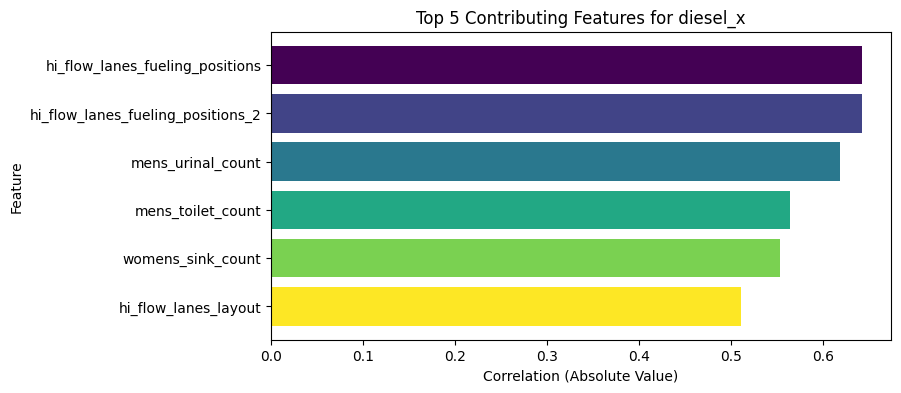

x7_min_emp                  0.240116
lottery                     0.236688
open_year                   0.221243
x5_min_emp                  0.208143
x7_min_pop                  0.203366
years_since_last_project    0.201761
Name: unleaded, dtype: float64


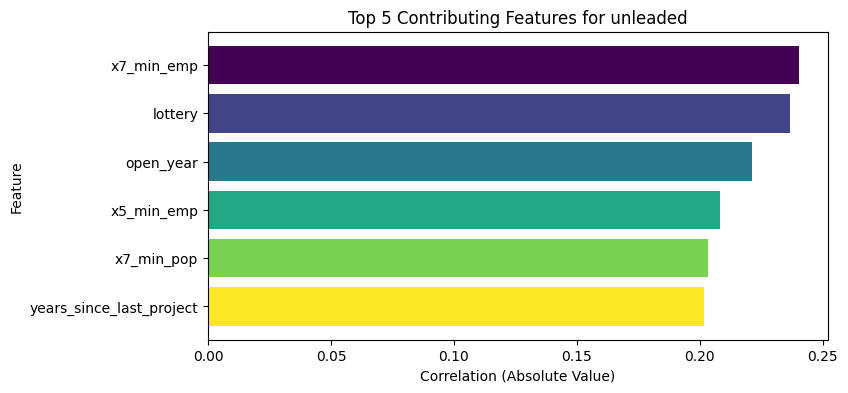

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define your target variables
target_variables = ['daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel_x', 'unleaded']

# Initialize a DataFrame to store correlation results
correlation_results = pd.DataFrame(index=bonfire.columns, columns=target_variables)

# Calculate correlations for each target variable
for target in target_variables:
    correlations = bonfire.corr()[target]
    correlation_results[target] = correlations.abs().sort_values(ascending=False)

# Create horizontal bar plots for the top 5 contributing features for each target variable using Matplotlib
colors = plt.cm.viridis(np.linspace(0, 1, 6))  # Create a color palette
for target in target_variables:
    top_contributors = correlation_results[target].nlargest(8)  # Get the top 5 contributors + the target itself
    top_contributors = top_contributors[~top_contributors.index.isin(target_variables)]
  # Drop the target variable itself
    print(top_contributors)

    # # Create a horizontal bar plot
    plt.figure(figsize=(8, 4))
    plt.barh(top_contributors.index, top_contributors.values, color=colors)

    # # Customize the appearance
    plt.xlabel('Correlation (Absolute Value)')
    plt.ylabel('Feature')
    plt.title(f'Top 5 Contributing Features for {target}')
    plt.gca().invert_yaxis()  # Invert the y-axis to show the top contributor at the top

    # # Show the plot
    plt.show()


                                  calendar.fiscal_week_id_for_year  \
calendar.fiscal_week_id_for_year                               1.0   
calendar.day_of_week                                           NaN   
calendar_information.holiday                                   NaN   
calendar_information.type_of_day                               NaN   
daily_yoy_ndt.total_inside_sales                               NaN   
...                                                            ...   
self_check_out                                                 NaN   
mens_toilet_count                                              NaN   
mens_urinal_count                                              NaN   
womens_toilet_count                                            NaN   
womens_sink_count                                              NaN   

                                  calendar.day_of_week  \
calendar.fiscal_week_id_for_year                   NaN   
calendar.day_of_week                       

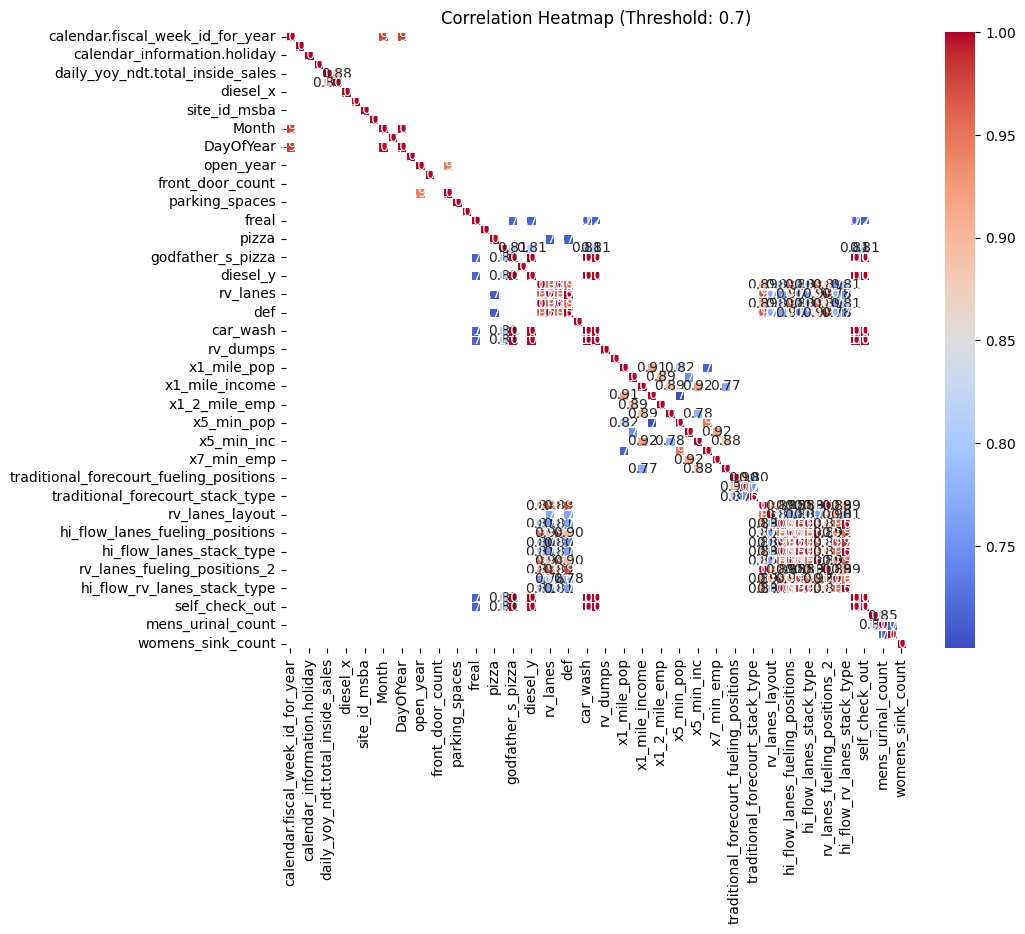

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'bonfire' is your DataFrame with relevant data

# Set correlation threshold
correlation_threshold = 0.7  # Adjust as needed

# Create a correlation matrix
correlation_matrix = bonfire.corr()

# Filter the correlation matrix based on the threshold
correlation_matrix_filtered = correlation_matrix.abs().mask(correlation_matrix.abs() < correlation_threshold)
print(correlation_matrix_filtered)
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Customize the appearance
plt.title(f'Correlation Heatmap (Threshold: {correlation_threshold})')
plt.show()


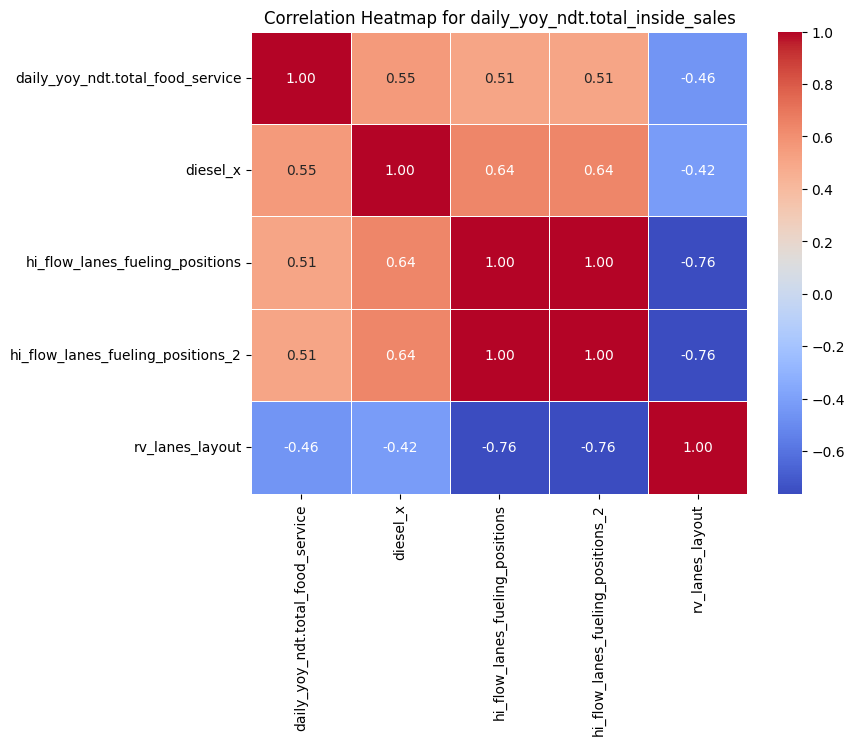

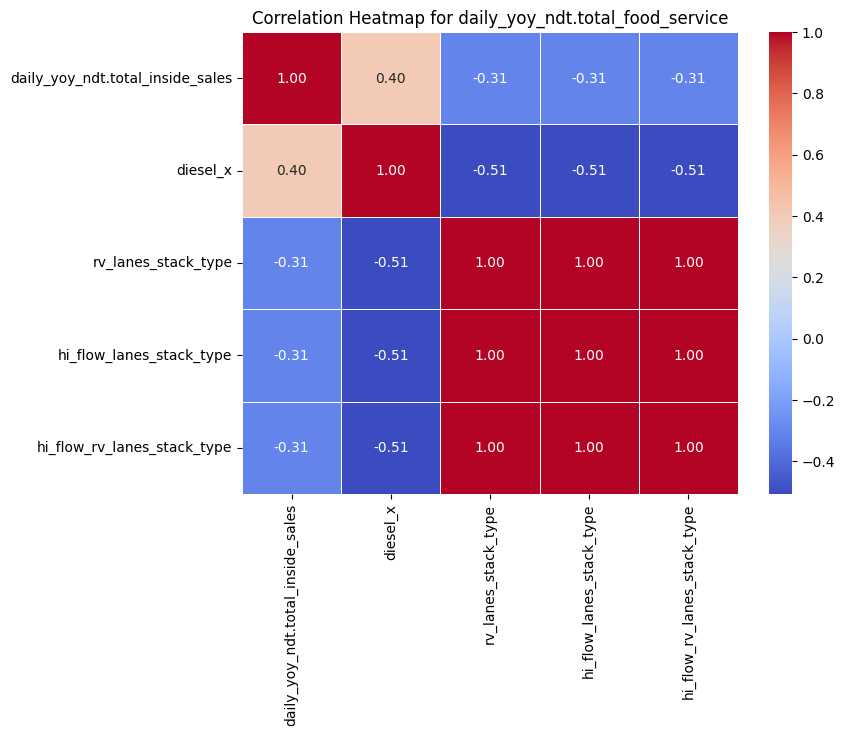

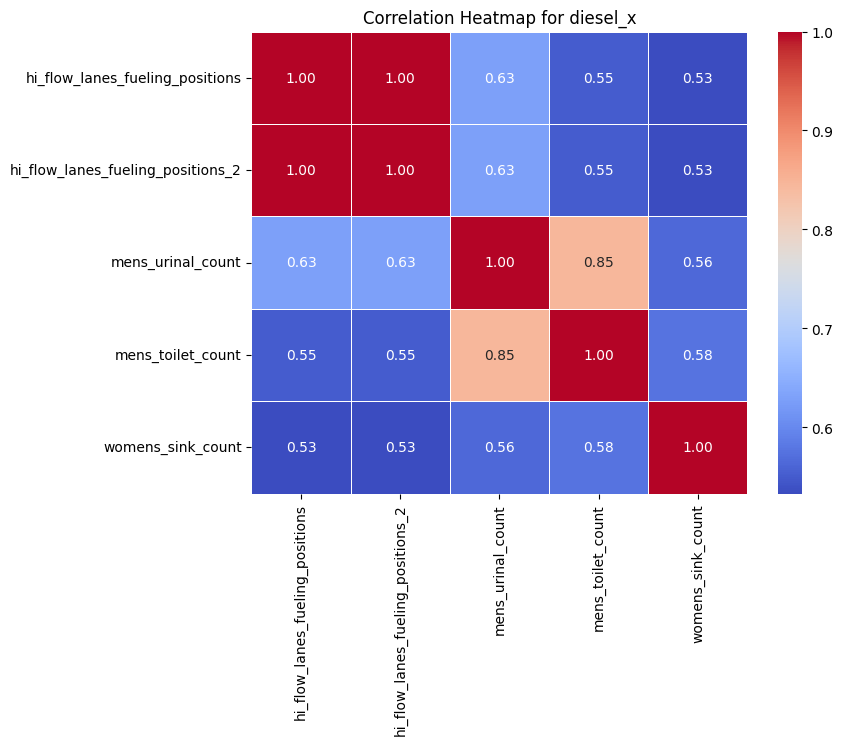

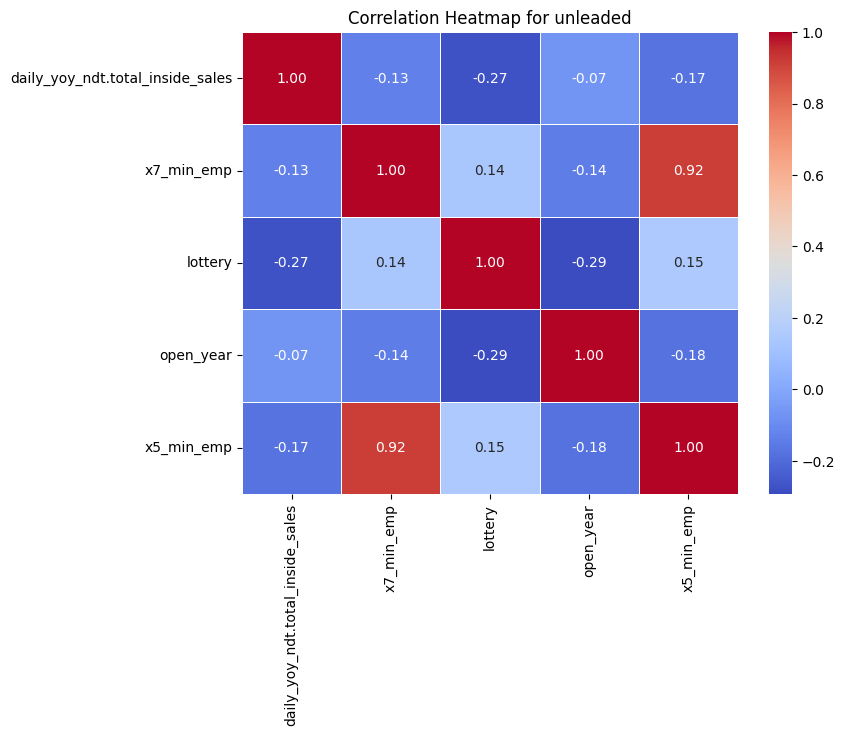

In [ ]:


# Define your target variables
target_variables = ['daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel_x', 'unleaded']

# Initialize a DataFrame to store correlation results
correlation_results = pd.DataFrame(index=bonfire.columns, columns=target_variables)

# Calculate correlations for each target variable
for target in target_variables:
    correlations = bonfire.corr()[target]
    correlation_results[target] = correlations.abs().sort_values(ascending=False)

# Create a heatmap for each target variable
for target in target_variables:
    top_contributors = correlation_results[target].nlargest(6)  # Get the top 5 contributors + the target itself
    top_contributors = top_contributors.drop(target)  # Drop the target variable itself

    # Create a subset DataFrame for the heatmap
    heatmap_data = bonfire[top_contributors.index].corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(8, 6))

    # Create a heatmap using seaborn
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

    # Customize the appearance
    plt.title(f'Correlation Heatmap for {target}')
    plt.show()


## XGB Datasets

#<a name = "MD">Modelling Development</a>

#<a name = "XG">XGB Model</a>

In [ ]:
top_features=['calendar.fiscal_week_id_for_year','calendar.day_of_week','calendar_information.holiday',
'calendar_information.type_of_day','years_since_last_project','hi_flow_lanes_fueling_positions','hi_flow_lanes_fueling_positions_2','rv_lanes_layout','rv_lanes_stack_type',
'hi_flow_lanes_stack_type','hi_flow_rv_lanes_stack_type','mens_urinal_count','mens_toilet_count','womens_sink_count',
'x7_min_emp','lottery','x5_min_emp','site_id_msba','Year','Month','Day','DayOfYear','season','square_feet']

In [ ]:
# Identify unique site_id_msba values
import random

random.seed(1432)
unique_site_ids = bonfire['site_id_msba'].unique()

# Randomly choose three site_id_msba for testing
hold_site_ids = np.random.choice(unique_site_ids, 3, replace=False)  # replace=False ensures no duplicate selections

print("Hold Site IDs:", hold_site_ids)

Hold Site IDs: [23380 22925 23450]


## for Inside sales

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

bonfire_inside = bonfire[['daily_yoy_ndt.total_inside_sales'] + top_features]

# Create lagged features
# lagged_columns = ['lag1', 'lag2', 'lag3']  # Adjust the number of lagged features as needed

# for lag in range(1, len(lagged_columns) + 1):
#     bonfire_inside[f'lag{lag}'] = bonfire_inside['daily_yoy_ndt.total_inside_sales'].shift(lag)

# # Create rolling statistics
# rolling_columns = ['rolling_mean', 'rolling_std']  # Adjust the rolling statistics as needed

# for window_size in [7, 14, 21]:  # Adjust the window sizes as needed
#     bonfire_inside[f'rolling_mean_{window_size}'] = bonfire_inside['daily_yoy_ndt.total_inside_sales'].rolling(window=window_size).mean()
#     bonfire_inside[f'rolling_std_{window_size}'] = bonfire_inside['daily_yoy_ndt.total_inside_sales'].rolling(window=window_size).std()

# bonfire_inside = bonfire_inside.fillna(bonfire_inside.mean())

# Split the data into training and hold sets
hold_data = bonfire_inside[bonfire_inside['site_id_msba'].isin(hold_site_ids)]
training_data = bonfire_inside[~bonfire_inside['site_id_msba'].isin(hold_site_ids)]

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_train and y_train are your training datasets

# Separate features and target variable
# Drop 'site_id_msba' from the datasets
X_training = training_data.drop(['daily_yoy_ndt.total_inside_sales', 'site_id_msba'], axis=1)
y_training = training_data['daily_yoy_ndt.total_inside_sales']

X_hold = hold_data.drop(['daily_yoy_ndt.total_inside_sales', 'site_id_msba'], axis=1)
X_hold1 = hold_data.drop(['daily_yoy_ndt.total_inside_sales'], axis=1)
y_hold = hold_data['daily_yoy_ndt.total_inside_sales']

# Split the data into training and test sets (You can use the train_test_split function for this)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# Create an XGBoost regressor model
xgb_model = XGBRegressor(verbosity=0)  # You can set other hyperparameters as needed

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03]
}
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

y_pred_hold = best_xgb_model.predict(X_hold)
hold_results_df = pd.DataFrame({'Actual': y_hold, 'Predicted': y_pred_hold})
hold_results_df = pd.concat([X_hold1, hold_results_df], axis=1)

# Create a new column 'full_date' by combining 'day', 'month', and 'year'
hold_results_df['full_date'] = pd.to_datetime(hold_results_df[['Year', 'Month', 'Day']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 250}
Mean Squared Error (MSE): 124599.85122603043
Root Mean Squared Error (RMSE): 352.98704115878024
Mean Absolute Error (MAE): 256.0304421813631
R^2 Score: 0.8764736990872903


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 14
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    predicted_total1= site_data['Predicted'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')

    print(f'Total Sum for Predicted Data (Site ID {site_id}): {predicted_total1}')

    print(f'two_week RMSE-inside sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')


    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()



Total Sum for Actual Data (Site ID 22925): 1035183.604
Total Sum for Predicted Data (Site ID 22925): 768446.875
two_week RMSE-inside sales for (Site ID 22925): 261703
Total Sum for Actual Data (Site ID 23450): 948417.3544999999
Total Sum for Predicted Data (Site ID 23450): 1140509.75
two_week RMSE-inside sales for (Site ID 23450): 177144
Total Sum for Actual Data (Site ID 23380): 1185017.7605
Total Sum for Predicted Data (Site ID 23380): 1341221.375
two_week RMSE-inside sales for (Site ID 23380): 138874


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 14
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    predicted_total1= site_data['Predicted'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')

    print(f'Total Sum for Predicted Data (Site ID {site_id}): {predicted_total1}')

    print(f'two_week RMSE-inside sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')


    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()



In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 21
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    # print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')

    print(f'three_week RMSE-inside sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')


    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()



three_week RMSE-inside sales for (Site ID 22925): 256582
three_week RMSE-inside sales for (Site ID 23450): 170170
three_week RMSE-inside sales for (Site ID 23380): 135114


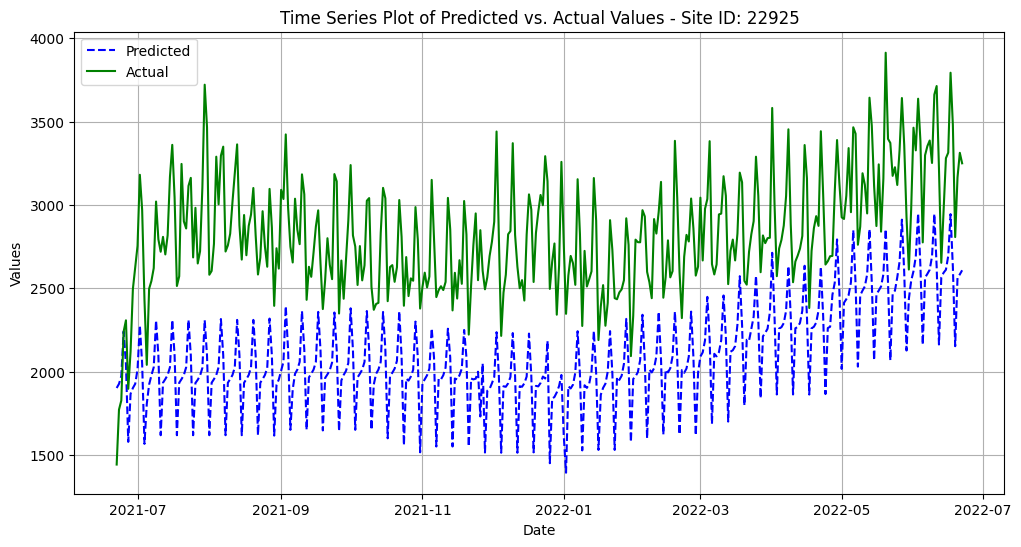

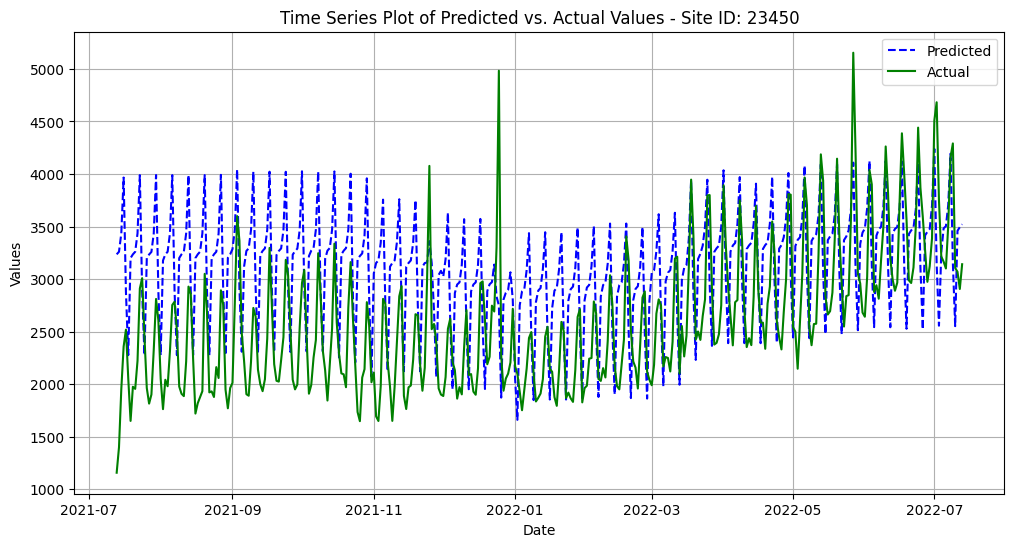

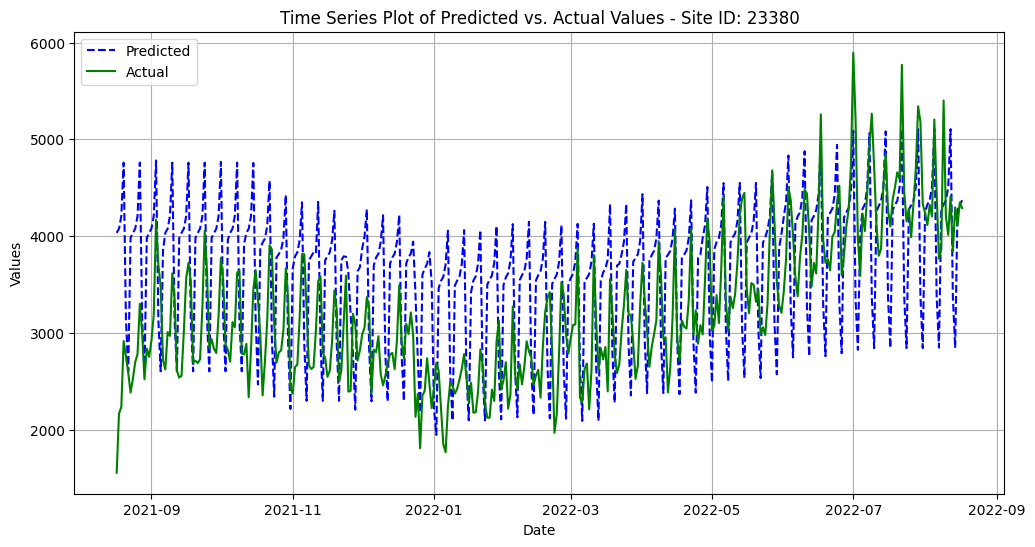

Site ID: 22925
Total Actual: 1035183.60
Total Predicted: 768446.88
Percentage change: 25.76709367974109

Site ID: 23450
Total Actual: 948417.35
Total Predicted: 1140509.75
Percentage change: -20.253994150209337

Site ID: 23380
Total Actual: 1185017.76
Total Predicted: 1341221.38
Percentage change: -13.181542058415411



In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Calculate total sum of actual and predicted values for each site_id
total_actual_values = []
total_predicted_values = []

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date = pd.to_datetime(store_open_date)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Calculate total values
    total_actual = site_data['Actual'].sum()
    total_predicted = site_data['Predicted'].sum()

    # Append total values to the lists
    total_actual_values.append(total_actual)
    total_predicted_values.append(total_predicted)

    # Plot the 'Predicted' values
    plt.figure(figsize=(12, 6))
    plt.plot(site_data['full_date'], site_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # Plot the 'Actual' values
    plt.plot(site_data['full_date'], site_data['Actual'], label='Actual', color='green', linestyle='-')

    # Customize the plot
    plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the total sum of actual and predicted values for each site_id
for i, site_id in enumerate(unique_site_ids):
    print(f"Site ID: {site_id}")
    print(f"Total Actual: {total_actual_values[i]:.2f}")
    print(f"Total Predicted: {total_predicted_values[i]:.2f}")
    print(f"Percentage change: {((total_actual_values[i])-(total_predicted_values[i]))*100/(total_actual_values[i])}")
    print()


## for Food Services

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

bonfire_food = bonfire[['daily_yoy_ndt.total_food_service'] + top_features]

# # Create lagged features
# lagged_columns = ['lag1', 'lag2', 'lag3']  # Adjust the number of lagged features as needed

# for lag in range(1, len(lagged_columns) + 1):
#     bonfire_food[f'lag{lag}'] = bonfire_food['daily_yoy_ndt.total_food_service'].shift(lag)

# # Create rolling statistics
# rolling_columns = ['rolling_mean', 'rolling_std']  # Adjust the rolling statistics as needed

# for window_size in [7, 14, 21]:  # Adjust the window sizes as needed
#     bonfire_food[f'rolling_mean_{window_size}'] = bonfire_food['daily_yoy_ndt.total_food_service'].rolling(window=window_size).mean()
#     bonfire_food[f'rolling_std_{window_size}'] = bonfire_food['daily_yoy_ndt.total_food_service'].rolling(window=window_size).std()

# bonfire_food = bonfire_food.fillna(bonfire_food.mean())

# Split the data into training and hold sets
hold_data = bonfire_food[bonfire_food['site_id_msba'].isin(hold_site_ids)]
training_data = bonfire_food[~bonfire_food['site_id_msba'].isin(hold_site_ids)]

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_train and y_train are your training datasets

# Separate features and target variable
# Drop 'site_id_msba' from the datasets
X_training = training_data.drop(['daily_yoy_ndt.total_food_service', 'site_id_msba'], axis=1)
y_training = training_data['daily_yoy_ndt.total_food_service']

X_hold = hold_data.drop(['daily_yoy_ndt.total_food_service', 'site_id_msba'], axis=1)
X_hold1 = hold_data.drop(['daily_yoy_ndt.total_food_service'], axis=1)
y_hold = hold_data['daily_yoy_ndt.total_food_service']

# Split the data into training and test sets (You can use the train_test_split function for this)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# Create an XGBoost regressor model
xgb_model = XGBRegressor(verbosity=0)  # You can set other hyperparameters as needed

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03]
}
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

y_pred_hold = best_xgb_model.predict(X_hold)
hold_results_df = pd.DataFrame({'Actual': y_hold, 'Predicted': y_pred_hold})
hold_results_df = pd.concat([X_hold1, hold_results_df], axis=1)

# Create a new column 'full_date' by combining 'day', 'month', and 'year'
hold_results_df['full_date'] = pd.to_datetime(hold_results_df[['Year', 'Month', 'Day']])

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 250}
Mean Squared Error (MSE): 11041.12627603091
Root Mean Squared Error (RMSE): 105.07676373028868
Mean Absolute Error (MAE): 75.60020406544646
R^2 Score: 0.9095941626345192


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 14
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    predicted_total1= site_data['Predicted'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')
    print(f'Total Sum for Predicted Data (Site ID {site_id}): {predicted_total1}')

    print(f'two_week RMSE-Food sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')


    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()



Total Sum for Actual Data (Site ID 22925): 8454.5825
Total Sum for Actual Data (Site ID 22925): 216371.76049999997
Total Sum for Predicted Data (Site ID 22925): 170106.625
two_week RMSE-Food sales for (Site ID 22925): 44028
Total Sum for Actual Data (Site ID 23450): 7438.675999999999
Total Sum for Actual Data (Site ID 23450): 208904.95150000002
Total Sum for Predicted Data (Site ID 23450): 230715.375
two_week RMSE-Food sales for (Site ID 23450): 20625
Total Sum for Actual Data (Site ID 23380): 11679.759
Total Sum for Actual Data (Site ID 23380): 357002.6285
Total Sum for Predicted Data (Site ID 23380): 324169.15625
two_week RMSE-Food sales for (Site ID 23380): 34018


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 21
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    # print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')

    print(f'three_week RMSE-food sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')


    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()



three_week RMSE-food sales for (Site ID 22925): 42284
three_week RMSE-food sales for (Site ID 23450): 19988
three_week RMSE-food sales for (Site ID 23380): 33144


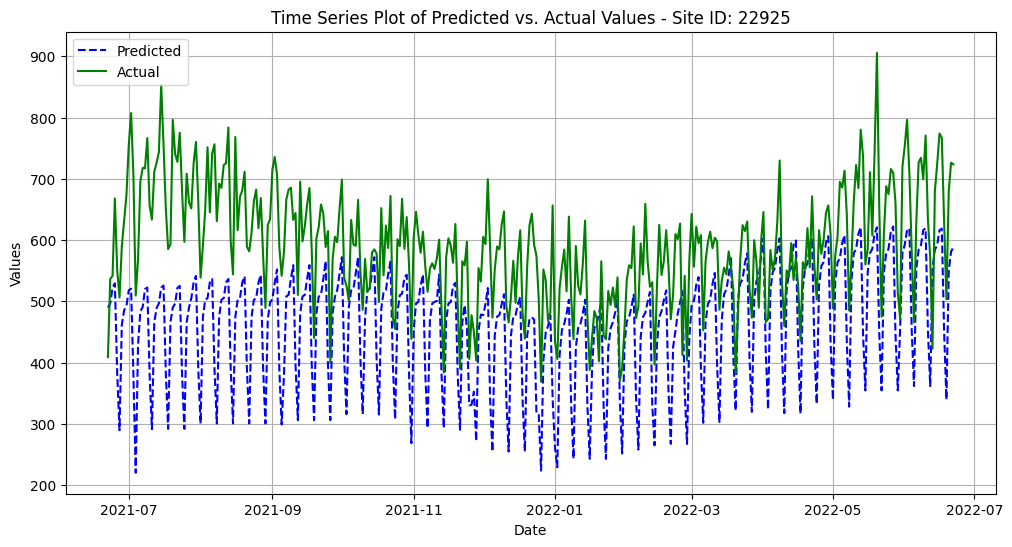

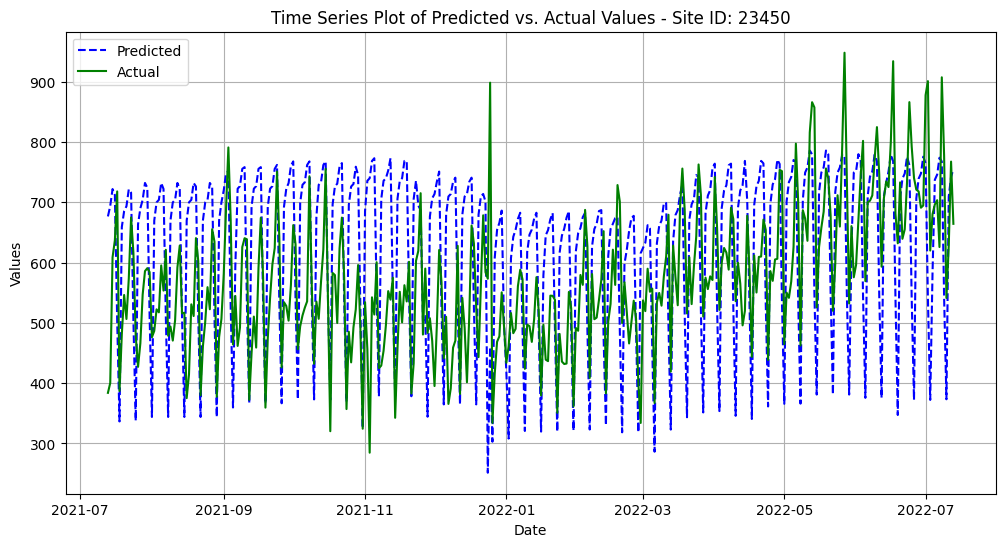

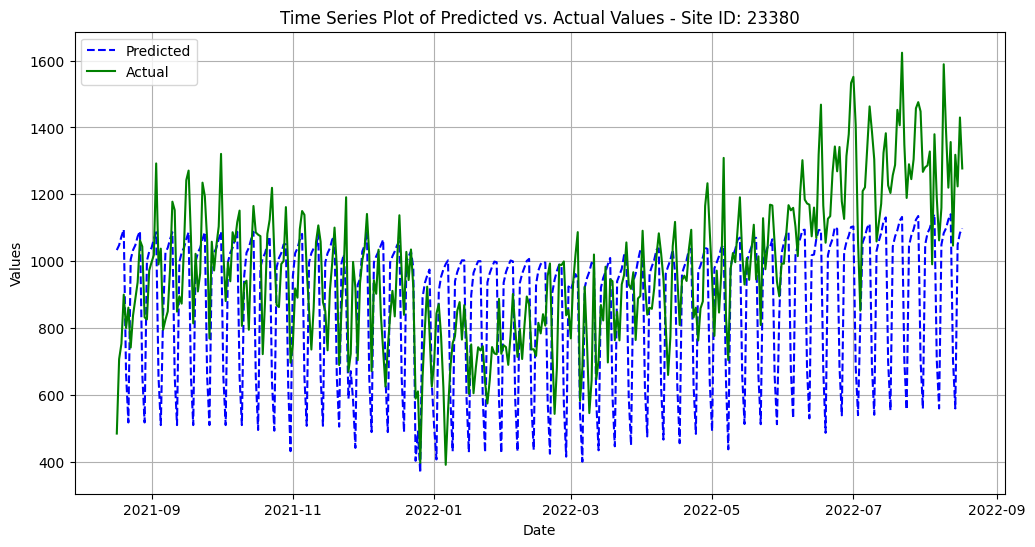

Site ID: 22925
Total Actual: 216371.76
Total Predicted: 170106.62
Percentage change: 21.382242947549514

Site ID: 23450
Total Actual: 208904.95
Total Predicted: 230715.38
Percentage change: -10.4403573698922

Site ID: 23380
Total Actual: 357002.63
Total Predicted: 324169.16
Percentage change: 9.196983335376197



In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Calculate total sum of actual and predicted values for each site_id
total_actual_values = []
total_predicted_values = []

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date = pd.to_datetime(store_open_date)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Calculate total values
    total_actual = site_data['Actual'].sum()
    total_predicted = site_data['Predicted'].sum()

    # Append total values to the lists
    total_actual_values.append(total_actual)
    total_predicted_values.append(total_predicted)

    # Plot the 'Predicted' values
    plt.figure(figsize=(12, 6))
    plt.plot(site_data['full_date'], site_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # Plot the 'Actual' values
    plt.plot(site_data['full_date'], site_data['Actual'], label='Actual', color='green', linestyle='-')

    # Customize the plot
    plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the total sum of actual and predicted values for each site_id
for i, site_id in enumerate(unique_site_ids):
    print(f"Site ID: {site_id}")
    print(f"Total Actual: {total_actual_values[i]:.2f}")
    print(f"Total Predicted: {total_predicted_values[i]:.2f}")
    print(f"Percentage change: {((total_actual_values[i])-(total_predicted_values[i]))*100/(total_actual_values[i])}")
    print()


##  Diesel

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

bonfire_diesel = bonfire[['diesel_x'] + top_features]

# # Create lagged features
# lagged_columns = ['lag1', 'lag2', 'lag3']  # Adjust the number of lagged features as needed

# for lag in range(1, len(lagged_columns) + 1):
#     bonfire_diesel[f'lag{lag}'] = bonfire_diesel['diesel_x'].shift(lag)

# # Create rolling statistics
# rolling_columns = ['rolling_mean', 'rolling_std']  # Adjust the rolling statistics as needed

# for window_size in [7, 14, 21]:  # Adjust the window sizes as needed
#     bonfire_diesel[f'rolling_mean_{window_size}'] = bonfire_diesel['diesel_x'].rolling(window=window_size).mean()
#     bonfire_diesel[f'rolling_std_{window_size}'] = bonfire_diesel['diesel_x'].rolling(window=window_size).std()

# bonfire_diesel = bonfire_diesel.fillna(bonfire_diesel.mean())

# Split the data into training and hold sets
hold_data = bonfire_diesel[bonfire_diesel['site_id_msba'].isin(hold_site_ids)]
training_data = bonfire_diesel[~bonfire_diesel['site_id_msba'].isin(hold_site_ids)]


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_train and y_train are your training datasets

# Separate features and target variable
# Drop 'site_id_msba' from the datasets
X_training = training_data.drop(['diesel_x', 'site_id_msba'], axis=1)
y_training = training_data['diesel_x']

X_hold = hold_data.drop(['diesel_x', 'site_id_msba'], axis=1)
X_hold1 = hold_data.drop(['diesel_x'], axis=1)
y_hold = hold_data['diesel_x']

# Split the data into training and test sets (You can use the train_test_split function for this)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# Create an XGBoost regressor model
xgb_model = XGBRegressor(verbosity=0)  # You can set other hyperparameters as needed

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03]
}
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

y_pred_hold = best_xgb_model.predict(X_hold)
hold_results_df = pd.DataFrame({'Actual': y_hold, 'Predicted': y_pred_hold})
hold_results_df = pd.concat([X_hold1, hold_results_df], axis=1)

# Create a new column 'full_date' by combining 'day', 'month', and 'year'
hold_results_df['full_date'] = pd.to_datetime(hold_results_df[['Year', 'Month', 'Day']])



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 250}
Mean Squared Error (MSE): 211984.8509731236
Root Mean Squared Error (RMSE): 460.4181262430092
Mean Absolute Error (MAE): 271.5841490073267
R^2 Score: 0.9560188999114952


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 14
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    predicted_total1= site_data['Predicted'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')


    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')
    print(f'Total Sum for Predicted Data (Site ID {site_id}): {predicted_total1}')

    print(f'two_week RMSE-Diesel sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')

    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()




Total Sum for Actual Data (Site ID 22925): 70646.57949999999
Total Sum for Predicted Data (Site ID 22925): 98277.28125
two_week RMSE-Diesel sales for (Site ID 22925): 26278
Total Sum for Actual Data (Site ID 23450): 184282.9345
Total Sum for Predicted Data (Site ID 23450): 110187.6328125
two_week RMSE-Diesel sales for (Site ID 23450): 72182
Total Sum for Actual Data (Site ID 23380): 776461.756
Total Sum for Predicted Data (Site ID 23380): 671849.875
two_week RMSE-Diesel sales for (Site ID 23380): 120453


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 21
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    predicted_total1= site_data['Predicted'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    # print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')

    print(f'Three_week RMSE-Diesel sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')

    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()




Three_week RMSE-Diesel sales for (Site ID 22925): 25554
Three_week RMSE-Diesel sales for (Site ID 23450): 71106
Three_week RMSE-Diesel sales for (Site ID 23380): 126471


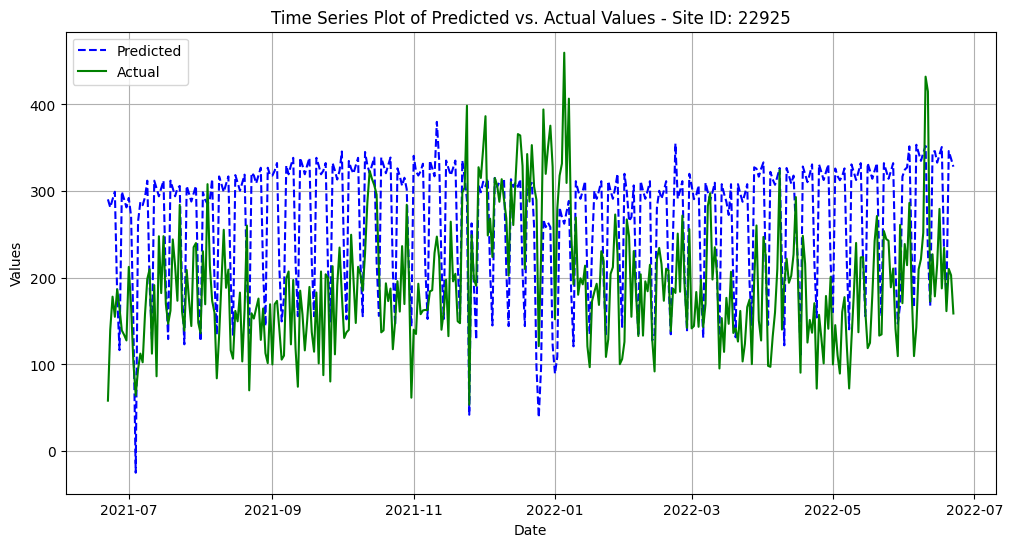

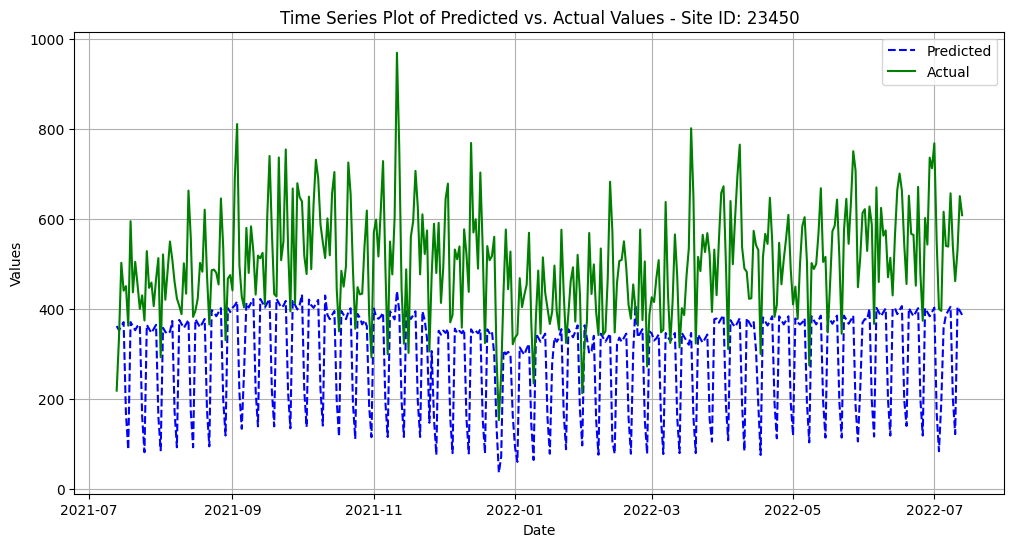

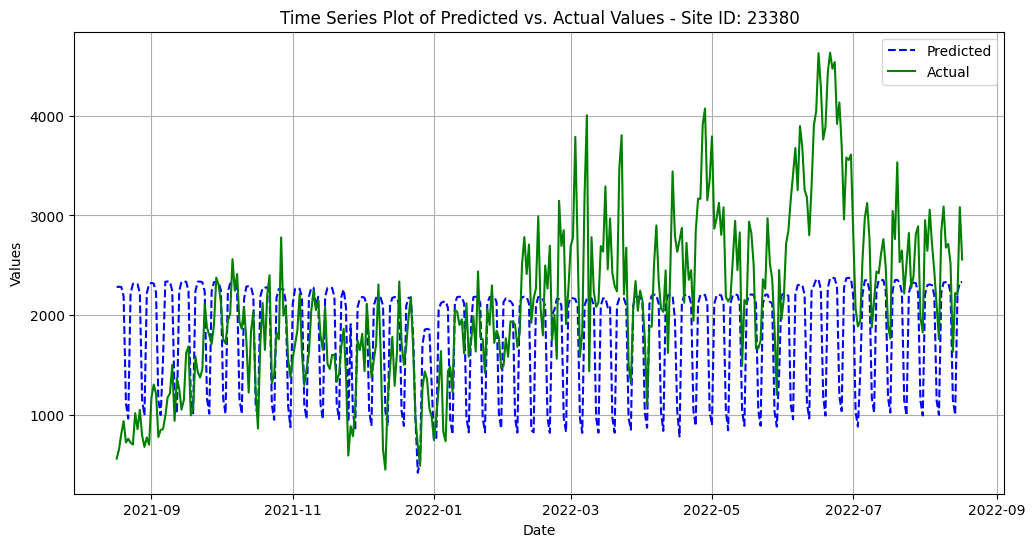

Site ID: 22925
Total Actual: 70646.58
Total Predicted: 98277.28
Percentage change: -39.11116708771443

Site ID: 23450
Total Actual: 184282.93
Total Predicted: 110187.63
Percentage change: 40.20735934585413

Site ID: 23380
Total Actual: 776461.76
Total Predicted: 671849.88
Percentage change: 13.472895502144995



In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Calculate total sum of actual and predicted values for each site_id
total_actual_values = []
total_predicted_values = []

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date = pd.to_datetime(store_open_date)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Calculate total values
    total_actual = site_data['Actual'].sum()
    total_predicted = site_data['Predicted'].sum()

    # Append total values to the lists
    total_actual_values.append(total_actual)
    total_predicted_values.append(total_predicted)

    # Plot the 'Predicted' values
    plt.figure(figsize=(12, 6))
    plt.plot(site_data['full_date'], site_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # Plot the 'Actual' values
    plt.plot(site_data['full_date'], site_data['Actual'], label='Actual', color='green', linestyle='-')

    # Customize the plot
    plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the total sum of actual and predicted values for each site_id
for i, site_id in enumerate(unique_site_ids):
    print(f"Site ID: {site_id}")
    print(f"Total Actual: {total_actual_values[i]:.2f}")
    print(f"Total Predicted: {total_predicted_values[i]:.2f}")
    print(f"Percentage change: {((total_actual_values[i])-(total_predicted_values[i]))*100/(total_actual_values[i])}")
    print()


##  Unleaded

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

bonfire_unleaded = bonfire[['unleaded'] + top_features]

# # Create lagged features
# lagged_columns = ['lag1', 'lag2', 'lag3']  # Adjust the number of lagged features as needed

# for lag in range(1, len(lagged_columns) + 1):
#     bonfire_unleaded[f'lag{lag}'] = bonfire_unleaded['unleaded'].shift(lag)

# # Create rolling statistics
# rolling_columns = ['rolling_mean', 'rolling_std']  # Adjust the rolling statistics as needed

# for window_size in [7, 14, 21]:  # Adjust the window sizes as needed
#     bonfire_unleaded[f'rolling_mean_{window_size}'] = bonfire_unleaded['unleaded'].rolling(window=window_size).mean()
#     bonfire_unleaded[f'rolling_std_{window_size}'] = bonfire_unleaded['unleaded'].rolling(window=window_size).std()

# bonfire_unleaded = bonfire_unleaded.fillna(bonfire_unleaded.mean())

# Split the data into training and hold sets
hold_data = bonfire_unleaded[bonfire_unleaded['site_id_msba'].isin(hold_site_ids)]
training_data = bonfire_unleaded[~bonfire_unleaded['site_id_msba'].isin(hold_site_ids)]


In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_train and y_train are your training datasets

# Separate features and target variable
# Drop 'site_id_msba' from the datasets
X_training = training_data.drop(['unleaded', 'site_id_msba'], axis=1)
y_training = training_data['unleaded']

X_hold = hold_data.drop(['unleaded', 'site_id_msba'], axis=1)
X_hold1 = hold_data.drop(['unleaded'], axis=1)
y_hold = hold_data['unleaded']

# Split the data into training and test sets (You can use the train_test_split function for this)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# Create an XGBoost regressor model
xgb_model = XGBRegressor(verbosity=0)  # You can set other hyperparameters as needed

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03]
}
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the regression metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

y_pred_hold = best_xgb_model.predict(X_hold)
hold_results_df = pd.DataFrame({'Actual': y_hold, 'Predicted': y_pred_hold})
hold_results_df = pd.concat([X_hold1, hold_results_df], axis=1)

# Create a new column 'full_date' by combining 'day', 'month', and 'year'
hold_results_df['full_date'] = pd.to_datetime(hold_results_df[['Year', 'Month', 'Day']])



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 250}
Mean Squared Error (MSE): 157108.48454390827
Root Mean Squared Error (RMSE): 396.3691266280817
Mean Absolute Error (MAE): 276.7993628775889
R^2 Score: 0.8555273512123553


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 14
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    predicted_total1= site_data['Predicted'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')
    print(f'Total Sum for Predicted Data (Site ID {site_id}): {predicted_total1}')


    print(f'two_week RMSE-unleaded sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')

    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()




Total Sum for Actual Data (Site ID 22925): 673401.6029999999
Total Sum for Predicted Data (Site ID 22925): 789050.5
two_week RMSE-unleaded sales for (Site ID 22925): 107744
Total Sum for Actual Data (Site ID 23450): 719450.0705
Total Sum for Predicted Data (Site ID 23450): 468847.3125
two_week RMSE-unleaded sales for (Site ID 23450): 239388
Total Sum for Actual Data (Site ID 23380): 1060127.3445000001
Total Sum for Predicted Data (Site ID 23380): 874191.3125
two_week RMSE-unleaded sales for (Site ID 23380): 187907


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

# Get input from the user and assign it to variable n
n = 21
# Assuming 'full_date', 'Predicted', 'Actual', and 'site_id_msba' are columns in hold_results_df

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date= pd.to_datetime(store_open_date)

    # print("store Open date:", store_open_date)
    start_date1= store_open_date + timedelta(days=n)

    # print("start date:", start_date1)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Print or use the calculated end_date
    # print("End date:", end_date)

    # # Create a DataFrame with dates from store_open_date to end_date
    # date_range = pd.date_range(start=start_date1, end=end_date, freq='D')
    # date_df = pd.DataFrame({'Date': date_range})
    predicted_data = site_data[site_data['full_date'] >= start_date1]
    actual_data = site_data[site_data['full_date'] < start_date1]

    combined_data = pd.concat([predicted_data[['full_date', 'Predicted']], actual_data[['full_date', 'Actual']]], ignore_index=True)
    # combined_data['total']= combined_data['Predicted']+ combined_data['Actual']

         # Add the 'Predicted' and 'Actual' values and store the result in the 'total' column
    combined_data['Pred_actual'] = combined_data['Predicted'].fillna(0) + combined_data['Actual'].fillna(0)
    actual_total = site_data[['full_date','Actual']]
    actual_total1= site_data['Actual'].sum()
    merged_data = pd.merge(combined_data, actual_total, on='full_date', how='inner')

    mse = mean_squared_error(merged_data['Pred_actual'], merged_data['Actual_y'])

    # Calculate the RMSE
    # rmse = np.sqrt(mse)

    # print("RMSE:", rmse)

    #     # Assuming 'value_column' is the column containing the values you want to sum (e.g., 'Predicted' or 'Actual')
    # value_column = 'Predicted'  # Replace with the actual column name

    # Calculate total sum for predicted_data
    total_sum_predicted = predicted_data['Predicted'].sum()
    # print(f'Total Sum for Predicted Data (Site ID {site_id}): {total_sum_predicted}')

    # Calculate total sum for actual_data
    total_sum_actual = actual_data['Actual'].sum()
    # print(f'Total Sum for Actual Data (Site ID {site_id}): {total_sum_actual}')

    # Calculate total sum for both predicted_data and actual_data
    total_forecast_actual = total_sum_predicted + total_sum_actual
    # print(f'Total Sum for Both Predicted and Actual Data (Site ID {site_id}): {total_forecast_actual}')

    print(f'Total Sum for Actual Data (Site ID {site_id}): {actual_total1}')
    print(f'Total Sum for Predicted Data (Site ID {site_id}): {predicted_total1}')

    print(f'Three_week RMSE-unleaded sales for (Site ID {site_id}): {int(abs(actual_total1-total_forecast_actual))}')

    # plt.figure(figsize=(12, 6))
    # plt.plot(predicted_data['full_date'], predicted_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # # Plot the 'Actual' values
    # plt.plot(actual_data['full_date'], actual_data['Actual'], label='Actual', color='green', linestyle='-')

    # # Customize the plot
    # plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}- Actual for : {n} days & predicted for {365-n} days')
    # plt.xlabel('Date')
    # plt.ylabel('Values')
    # plt.legend()
    # plt.grid(True)
    # plt.show()




Total Sum for Actual Data (Site ID 22925): 673401.6029999999
Total Sum for Predicted Data (Site ID 22925): 874191.3125
Three_week RMSE-unleaded sales for (Site ID 22925): 104342
Total Sum for Actual Data (Site ID 23450): 719450.0705
Total Sum for Predicted Data (Site ID 23450): 874191.3125
Three_week RMSE-unleaded sales for (Site ID 23450): 232943
Total Sum for Actual Data (Site ID 23380): 1060127.3445000001
Total Sum for Predicted Data (Site ID 23380): 874191.3125
Three_week RMSE-unleaded sales for (Site ID 23380): 185542


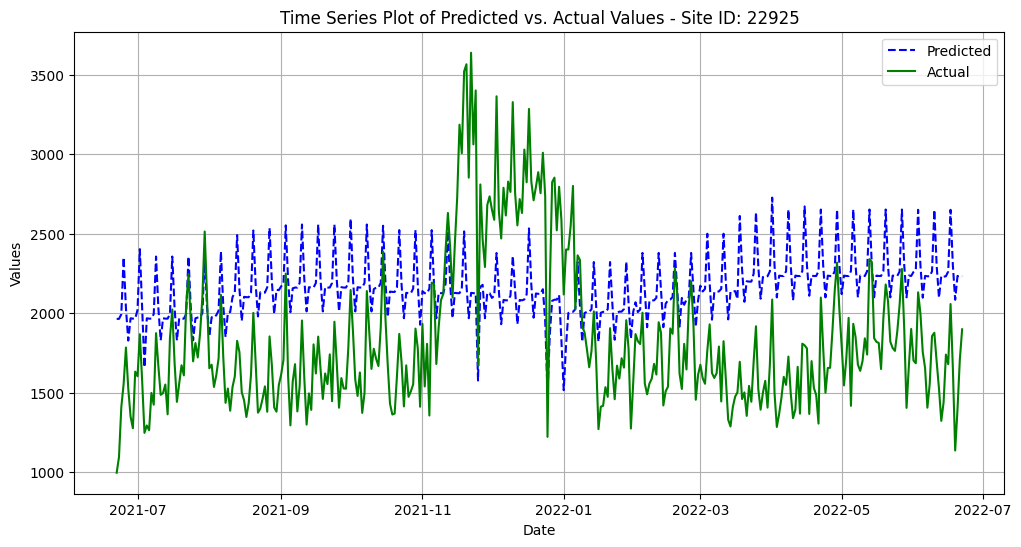

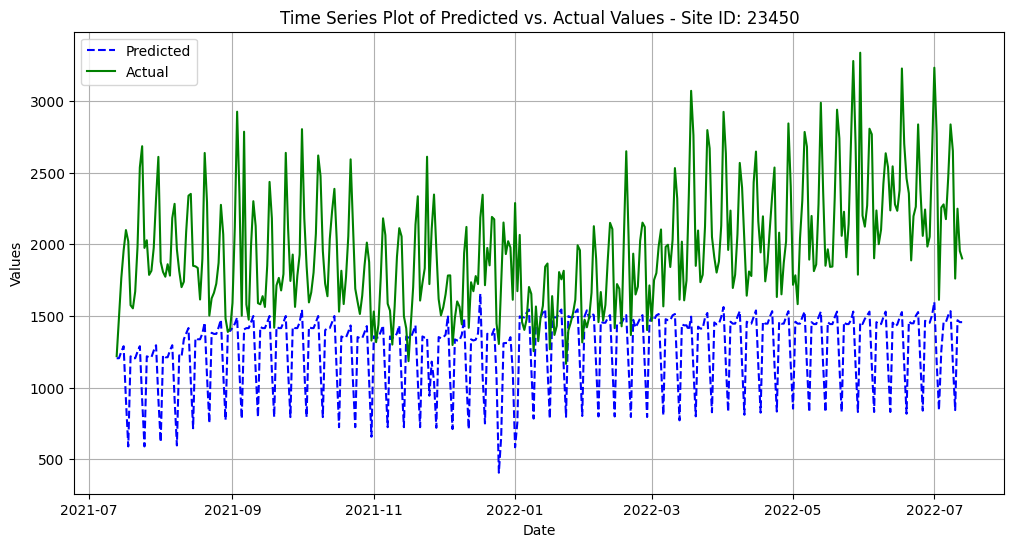

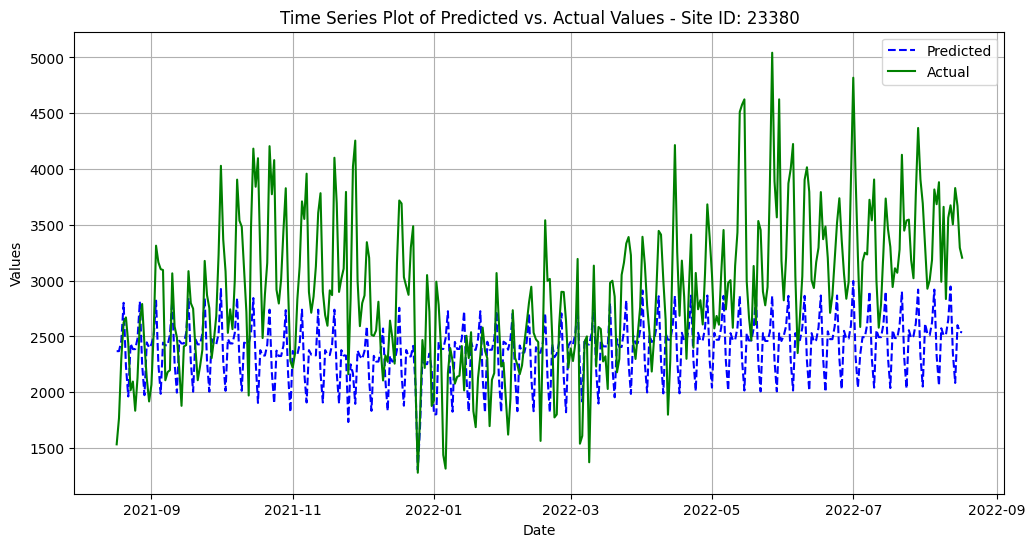

Site ID: 22925
Total Actual: 673401.60
Total Predicted: 789050.50
Percentage change: -17.173837496790178

Site ID: 23450
Total Actual: 719450.07
Total Predicted: 468847.31
Percentage change: 34.83254339329445

Site ID: 23380
Total Actual: 1060127.34
Total Predicted: 874191.31
Percentage change: 17.539028020043688



In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Get unique site_id_msba values
unique_site_ids = hold_results_df['site_id_msba'].unique()

# Calculate total sum of actual and predicted values for each site_id
total_actual_values = []
total_predicted_values = []

# Plotting the time series for each site_id_msba
for site_id in unique_site_ids:
    # Filter data for the current site_id_msba
    site_data = hold_results_df[hold_results_df['site_id_msba'] == site_id]
    store_open_date = min(site_data['full_date'])
    store_open_date = pd.to_datetime(store_open_date)

    # Calculate the end date by adding 365 days to store_open_date
    end_date = store_open_date + timedelta(days=365)

    # Calculate total values
    total_actual = site_data['Actual'].sum()
    total_predicted = site_data['Predicted'].sum()

    # Append total values to the lists
    total_actual_values.append(total_actual)
    total_predicted_values.append(total_predicted)

    # Plot the 'Predicted' values
    plt.figure(figsize=(12, 6))
    plt.plot(site_data['full_date'], site_data['Predicted'], label='Predicted', color='blue', linestyle='--')

    # Plot the 'Actual' values
    plt.plot(site_data['full_date'], site_data['Actual'], label='Actual', color='green', linestyle='-')

    # Customize the plot
    plt.title(f'Time Series Plot of Predicted vs. Actual Values - Site ID: {site_id}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the total sum of actual and predicted values for each site_id
for i, site_id in enumerate(unique_site_ids):
    print(f"Site ID: {site_id}")
    print(f"Total Actual: {total_actual_values[i]:.2f}")
    print(f"Total Predicted: {total_predicted_values[i]:.2f}")
    print(f"Percentage change: {((total_actual_values[i])-(total_predicted_values[i]))*100/(total_actual_values[i])}")
    print()


In [ ]:
bonfire.isnull().sum().sort_values()

In [ ]:
# Identify all categorical columns by selecting columns with data type 'object'
categorical_columns = bonfire.select_dtypes(include=['object']).columns

# Perform one-hot encoding for each categorical column
bonfire_encoded = pd.get_dummies(bonfire, columns=categorical_columns)

# The resulting 'bonfire_encoded' DataFrame now contains one-hot encoded columns for all categorical variables


In [ ]:
bonfire_encoded.info()

In [ ]:
bonfire_encoded.columns

##<a name = "TSD"> Time Series Decomposition </a>

###<a name = "TIS"> For total_inside_sales </a>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'daily_yoy_ndt.total_inside_sales'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)

# Sorting the data by date
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Performing seasonal decomposition
decomposition = seasonal_decompose(ts[sales_column_name].dropna(), model='additive', period=7)

# Plotting the original, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts[sales_column_name], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='best')
plt.tight_layout()

plt.show()




The key insights and observations for the **"total_inside_sales"** sales:

**Original Component:** The sales data ranges from 0 to 7000 and looks quite consistent over time. This means that sales don't have a clear up or down trend.

**Trend Component:** The "Trend" plot shows a pattern where sales go up in the summer and down in the winter. This suggests that sales follow a seasonal pattern, increasing at certain times of the year and decreasing at others. The range of this pattern is between 0 and 5000.

**Seasonal Component:** The "Seasonal" plot has a clear repeating pattern that goes from -20 to 40. This pattern shows that there are regular, recurring changes in sales throughout the year. Positive values mean sales are higher than usual, and negative values mean sales are lower than usual during those periods.

**Residual Component:** The "Residual" plot ranges from -2000 to 4000. It represents the random variations in sales that don't follow the trend or seasonal pattern. A large residual component suggests that there are still unexplained changes in the data.

Overall, the data related to total_inside_sales shows that sales have a clear pattern where they go up in the summer and down in the winter. This pattern is captured by the "Trend" and "Seasonal" components. The "Residual" component shows there are some random changes that we can't explain with this pattern.

###<a name = "TFS"> For total_food_service  </a>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'daily_yoy_ndt.total_food_service'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)

# Sorting the data by date
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Performing seasonal decomposition
decomposition = seasonal_decompose(ts[sales_column_name].dropna(), model='additive', period=7)

# Plotting the original, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts[sales_column_name], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='best')
plt.tight_layout()

plt.show()




The key insights and observations for the **"food_service"** sales:

**Original Component:** The initial time series data showed that daily food service values ranged from 0 to 2000 and looked fairly even, with no obvious strong pattern or repeated trends.

**Trend:** The trend part of the data had ups and downs between about 250 and 1250, showing that there were cycles or patterns. These patterns suggested that the sales went up (summer) and down (winter), indicating that there were certain times of the year when business was better or worse.

**Seasonal:** The seasonal part of the data covered the entire graph and went up and down between -5 and 10. This means that there was a regular pattern that repeated every day throughout the year.

**Residual:** The residual part of the data ranged from around -200 to 1000, which represented differences from the trends and seasonal patterns. This part had unexpected variations or random changes in the data that couldn't be explained by the regular patterns.

Overall, when we looked at the data closely, we found that there was a clear pattern that repeated every day and also some ups and downs that happened during the year.





###<a name = "TFS"> For diesel  </a>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'diesel_x'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)

# Sorting the data by date
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Performing seasonal decomposition
decomposition = seasonal_decompose(ts[sales_column_name].dropna(), model='additive', period=7)

# Plotting the original, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts[sales_column_name], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

The key insights and observations for the **"diesel"** sales:

**Original Component:** The original time series exhibits fluctuations and spikes, with values ranging from 0 to 20,000. The stretch of spikes in the center suggests that the graph has been impacted by site 21980 (high diesel sales) during this period.

**Trend component:** It ranges from 0 to 6,000, represents the long-term underlying pattern in the data. It also appears to be impacted by site 21980.

**Seasonal Component:** The seasonal component occupies the entire range from -50 to 50. This suggests that the seasonal component is relatively small in magnitude compared to the other components. The fact that it oscillates around zero means it doesn't significantly contribute to the overall values.

**Residual Component:** The residual component varies from -5,000 to 15,000, and it closely resembles the original and trend components. This indicates that the residual component contains a significant amount of variation and noise not captured by the trend or seasonal components.

In summary, the time series decomposition of diesel witnessed fluctations due to presence of site 21980. The model will be built by paying attention to this.

###<a name = "TFS"> For unleaded  </a>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'unleaded'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)

# Sorting the data by date
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Performing seasonal decomposition
decomposition = seasonal_decompose(ts[sales_column_name].dropna(), model='additive', period=7)

# Plotting the original, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts[sales_column_name], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='best')
plt.tight_layout()

plt.show()


The key insights and observations for the **"unleaded"** sales:

**Original Component:** The initial data, which represents sales, doesn't show any big ups or downs. Sales vary between 0 and 8000, but there's no clear trend.

**Trend Component:** There is a regular pattern in sales that goes from about 1000 to 4000. It means that sales tend to follow a similar path, with higher sales in summer and lower sales in winter.

**Seasonal Component:** This part represents the daily ups and downs in sales. It's a small range of changes, and it repeats regularly, regardless of the time of year.

**Residual Component:** This part shows unusual and unexplained changes in sales, ranging from -2000 to 4000. It means that the model used might not catch all the changes in the data, and there are still some unexplained patterns.

In summary, the breakdown of the data tells us that there's a daily sales pattern, a consistent trend with higher sales in summer and lower in winter, and some unknown variations in the data.

##<a name = "SC"> Stationarity Check</a>

###<a name = "TIS"> For total_inside_sales </a>

In [ ]:
from statsmodels.tsa.stattools import adfuller

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'daily_yoy_ndt.total_inside_sales'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Visual inspection of stationarity
plt.figure(figsize=(12, 6))
plt.plot(ts[sales_column_name], label='Sales Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data Over Time')
plt.legend()
plt.show()

# Augmented Dickey-Fuller test
result = adfuller(ts[sales_column_name].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

if result[1] <= 0.05:
    print('The data is stationary (reject the null hypothesis)')
else:
    print('The data is not stationary (fail to reject the null hypothesis)')


###<a name = "TFS"> For total_food_service  </a>

In [ ]:
from statsmodels.tsa.stattools import adfuller

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'daily_yoy_ndt.total_food_service'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Visual inspection of stationarity
plt.figure(figsize=(12, 6))
plt.plot(ts[sales_column_name], label='Sales Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data Over Time')
plt.legend()
plt.show()

# Augmented Dickey-Fuller test
result = adfuller(ts[sales_column_name].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

if result[1] <= 0.05:
    print('The data is stationary (reject the null hypothesis)')
else:
    print('The data is not stationary (fail to reject the null hypothesis)')


###<a name = "TFS"> For diesel  </a>

In [ ]:
from statsmodels.tsa.stattools import adfuller

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'diesel_x'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Visual inspection of stationarity
plt.figure(figsize=(12, 6))
plt.plot(ts[sales_column_name], label='Sales Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data Over Time')
plt.legend()
plt.show()

# Augmented Dickey-Fuller test
result = adfuller(ts[sales_column_name].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

if result[1] <= 0.05:
    print('The data is stationary (reject the null hypothesis)')
else:
    print('The data is not stationary (fail to reject the null hypothesis)')


###<a name = "TFS"> For unleaded  </a>

In [ ]:
from statsmodels.tsa.stattools import adfuller

date_column_name = 'calendar.calendar_day_date'
sales_column_name = 'unleaded'

# Creating a time series with the date column as the index
ts = bonfire.set_index(date_column_name)
ts = ts.sort_index()

# Converting the 'daily_yoy_ndt.total_inside_sales' column to numeric
ts[sales_column_name] = pd.to_numeric(ts[sales_column_name], errors='coerce')

# Visual inspection of stationarity
plt.figure(figsize=(12, 6))
plt.plot(ts[sales_column_name], label='Sales Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data Over Time')
plt.legend()
plt.show()

# Augmented Dickey-Fuller test
result = adfuller(ts[sales_column_name].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

if result[1] <= 0.05:
    print('The data is stationary (reject the null hypothesis)')
else:
    print('The data is not stationary (fail to reject the null hypothesis)')


It can be clearly observed that all target variables are stationary and we can reject the null hypothesis. By, interpreting p-value, ADF statistic values, the stationarity can be confirmed. The stationarity check is crucial for models like ARIMA and SARIMA.

##<a name = "DC"> Data Clustering</a>

###<a name = "CSP"> Clustering based on Store Parameters</a>

In [ ]:
store_features_cleaned.head()

In [ ]:

categorical_columns = store_features_cleaned.select_dtypes(include=['object']).columns

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

store_features_en= copy.deepcopy(store_features_cleaned)

# Encode each categorical column
for col in categorical_columns:
    store_features_en[col] = label_encoder.fit_transform(store_features_en[col])


The code is using scikit-learn's `LabelEncoder` to transform categorical columns in the `store_features_cleaned` DataFrame into numerical labels. It loops through the categorical columns, fits the encoder to each column's unique values, and replaces the original categorical data in a deep copy of the DataFrame called `store_features_en` with the corresponding numerical labels, making the data suitable for machine learning algorithms that require numerical input

In [ ]:
columns_to_standardize = [
    'square_feet', 'front_door_count', 'years_since_last_project', 'parking_spaces', 'lottery', 'freal',
     'bonfire_grill', 'pizza', 'cinnabon', 'godfather_s_pizza', 'ethanol_free', 'diesel', 'hi_flow_lanes',
     'rv_lanes', 'hi_flow_rv_lanes', 'def', 'cat_scales', 'car_wash', 'ev_charging', 'rv_dumps', 'propane',
     'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 'x1_2_mile_income', 'x5_min_pop',
     'x5_min_emp', 'x5_min_inc', 'x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'traditional_forecourt_fueling_positions',
     'traditional_forecourt_layout', 'traditional_forecourt_stack_type', 'rv_lanes_fueling_positions', 'rv_lanes_layout',
     'rv_lanes_stack_type', 'hi_flow_lanes_fueling_positions', 'hi_flow_lanes_layout', 'hi_flow_lanes_stack_type',
     'hi_flow_lanes_fueling_positions_2', 'rv_lanes_fueling_positions_2', 'hi_flow_rv_lanes_layout', 'hi_flow_rv_lanes_stack_type',
     'non_24_hour', 'self_check_out', 'mens_toilet_count', 'mens_urinal_count', 'womens_toilet_count', 'womens_sink_count']

# Creating a DataFrame with only the columns to standardize
store_features_subset = store_features_en[columns_to_standardize]

# Standardizing the selected columns
scaler = StandardScaler()
store_features_standardized_subset = scaler.fit_transform(store_features_subset)

# Creating a DataFrame with the standardized data and keep the 'site_id_msba' and 'open_year' columns
store_features_standardized = store_features_en.copy()
store_features_standardized[columns_to_standardize] = store_features_standardized_subset


The code is using scikit-learn's `StandardScaler` to standardize a subset of numerical columns in the `store_features_en` DataFrame, which involves transforming the selected columns to have a mean of 0 and a standard deviation of 1. The columns to standardize are specified in `columns_to_standardize`, and a new DataFrame `store_features_standardized_df` is created, which retains the original 'site_id_msba' and 'open_year' columns while replacing the selected columns with their standardized versions. This process ensures that the data is on the same scale and is ready for use with machine learning algorithms that may be sensitive to the scale of the input features.

In [ ]:
# Specification of the number of clusters (4 in your case)
num_clusters = 4

# Selecting the columns to be used for clustering
features_to_cluster = store_features_standardized[
    ['square_feet', 'front_door_count', 'years_since_last_project', 'parking_spaces', 'lottery', 'freal',
     'bonfire_grill', 'pizza', 'cinnabon', 'godfather_s_pizza', 'ethanol_free', 'diesel', 'hi_flow_lanes',
     'rv_lanes', 'hi_flow_rv_lanes', 'def', 'cat_scales', 'car_wash', 'ev_charging', 'rv_dumps', 'propane',
     'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 'x1_2_mile_income', 'x5_min_pop',
     'x5_min_emp', 'x5_min_inc', 'x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'traditional_forecourt_fueling_positions',
     'traditional_forecourt_layout', 'traditional_forecourt_stack_type', 'rv_lanes_fueling_positions', 'rv_lanes_layout',
     'rv_lanes_stack_type', 'hi_flow_lanes_fueling_positions', 'hi_flow_lanes_layout', 'hi_flow_lanes_stack_type',
     'hi_flow_lanes_fueling_positions_2', 'rv_lanes_fueling_positions_2', 'hi_flow_rv_lanes_layout', 'hi_flow_rv_lanes_stack_type',
     'non_24_hour', 'self_check_out', 'mens_toilet_count', 'mens_urinal_count', 'womens_toilet_count', 'womens_sink_count']
]

# Creating a K-Means model with the desired number of clusters
kmeans_stores = KMeans(n_clusters=num_clusters, random_state=0)

# Fitting the K-Means model to your data, excluding 'site_id_msba'
kmeans_stores.fit(features_to_cluster)

# Assigning cluster labels to each data point
store_features_standardized['cluster'] = kmeans_stores.labels_



The code is using the K-Means clustering algorithm from scikit-learn to cluster data from a specified subset of columns in the `store_features_standardized` DataFrame into a predefined number of clusters (4 in this case). It creates a K-Means model with four clusters, fits the model to the selected features, assigns cluster labels to each data point, and stores these labels in a new 'cluster' column in the DataFrame. This allows for grouping the data points into clusters based on their similarity in the chosen features, aiding in the analysis and segmentation of the dataset.

In [ ]:
# Creating an empty dictionary to store the associations
cluster_to_unique_sites = {}

# Iterating through the dataset
for index, row in store_features_standardized.iterrows():
    cluster_number = row['cluster']
    site_id_msba = row['site_id_msba']

    # Checking if the cluster number is already in the dictionary
    if cluster_number in cluster_to_unique_sites:
        cluster_to_unique_sites[cluster_number].add(site_id_msba)
    else:
        cluster_to_unique_sites[cluster_number] = {site_id_msba}

# Printing the unique site_id_msba values for each cluster
for cluster, unique_sites in cluster_to_unique_sites.items():
    print(f"Cluster {cluster}: Unique Site IDs - {', '.join(map(str, unique_sites))}")


The provided output presents the clusters along with their respective site IDs. Notably, Site ID 22715 stands out in a separate cluster. This separation is primarily attributed to the dissimilarity in store attributes when compared to the other sites in the dataset. This unique clustering underscores the distinct characteristics or features of Site ID 22715, setting it apart from the rest of the data points, which exhibit more similarities in terms of their store attributes

###<a name = "DC"> Merged Dataset with Cluster Number</a>

In [ ]:
#Merge dataset
timeseries_cleaned= copy.deepcopy(timeseries)
timeseries_cleaned.reset_index(inplace=True)
bonfire_cluster_total = timeseries_cleaned.merge(store_features_standardized, on='site_id_msba', how='inner')

#Top 5 rows of data overview
bonfire_cluster_total.head()

In [ ]:
categorical_columns = bonfire_cluster_total.select_dtypes(include=['object']).columns
# Initializing the LabelEncoder

label_encoder = LabelEncoder()
# Encode each categorical column
for col in categorical_columns:
    bonfire_cluster_total[col] = label_encoder.fit_transform(bonfire_cluster_total[col])

In [ ]:
bonfire_cluster_total.info()

###<a name = "DC">Bonfire Dataset Clusters</a>

In [ ]:
bonfire_cluster1 = bonfire_cluster_total[bonfire_cluster_total['cluster'] == 0]
bonfire_cluster2 = bonfire_cluster_total[bonfire_cluster_total['cluster'] == 1]
bonfire_cluster3 = bonfire_cluster_total[bonfire_cluster_total['cluster'] == 2]
bonfire_cluster4 = bonfire_cluster_total[bonfire_cluster_total['cluster'] == 3]

The code above provides a comprehensive view of the total datasets, organized based on their respective clusters. This arrangement is essential for conducting further in-depth analysis of the data

####<a name = "BC1">Bonfire_cluster1</a>

In [ ]:
selected_columns = ['calendar.calendar_day_date',
                    'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
                    'diesel_x', 'unleaded']

# Creating a new DataFrame with the selected columns
bonfire_cluster1 = bonfire_cluster1[selected_columns].copy()

# Group by 'calendar.calendar_day_date' and calculate the mean for other columns
# bonfire_cluster1 = bonfire_cluster1.groupby('calendar.calendar_day_date','capital_projects.soft_opening_date').mean().reset_index()
bonfire_cluster1 = bonfire_cluster1.groupby(['calendar.calendar_day_date']).mean().reset_index()

In [ ]:
bonfire_cluster1.head()

In [ ]:
x = bonfire_cluster1['calendar.calendar_day_date']
y1 = bonfire_cluster1['daily_yoy_ndt.total_inside_sales']
y2 = bonfire_cluster1['daily_yoy_ndt.total_food_service']
y3 = bonfire_cluster1['diesel_x']
y4 = bonfire_cluster1['unleaded']

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Set Seaborn style

# Plotting the data using Seaborn
sns.lineplot(x=x, y=y1, label='inside_sales',  color='b')
sns.lineplot(x=x, y=y2, label='food_service',  linestyle='--', color='g')
sns.lineplot(x=x, y=y3, label='diesel_x',  linestyle='-.', color='r')
sns.lineplot(x=x, y=y4, label='unleaded',  linestyle=':', color='c')

plt.xlabel('calendar.calendar_day_date')
plt.ylabel('Your Y-axis Label')
plt.title('Line Chart for Multiple Variables')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.legend()  # Display the legend to differentiate lines for different variables

plt.show()

The depicted plot above offers an insightful view of the data associated with Cluster 1. The X-axis is dedicated to the representation of dates, serving as a timeline reference. Meanwhile, the Y-axis portrays the average values of the target variables, providing a clear indication of the trends and patterns within this specific cluster over time.

####<a name = "BC1">Bonfire_cluster2</a>

In [ ]:
# Assuming 'bonfire' is your original DataFrame
selected_columns = ['calendar.calendar_day_date',
                    'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
                    'diesel_x', 'unleaded']

# Create a new DataFrame with the selected columns
bonfire_cluster2 = bonfire_cluster2[selected_columns].copy()

# Group by 'calendar.calendar_day_date' and calculate the mean for other columns
# bonfire_cluster1 = bonfire_cluster1.groupby('calendar.calendar_day_date','capital_projects.soft_opening_date').mean().reset_index()
bonfire_cluster2 = bonfire_cluster2.groupby(['calendar.calendar_day_date']).mean().reset_index()

# The 'averaged_df' DataFrame now contains the desired columns and average values


In [ ]:
bonfire_cluster2.head()

In [ ]:
x = bonfire_cluster2['calendar.calendar_day_date']
y1 = bonfire_cluster2['daily_yoy_ndt.total_inside_sales']
y2 = bonfire_cluster2['daily_yoy_ndt.total_food_service']
y3 = bonfire_cluster2['diesel_x']
y4 = bonfire_cluster2['unleaded']

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Set Seaborn style

# Plot the data using Seaborn
sns.lineplot(x=x, y=y1, label='inside_sales',  color='b')
sns.lineplot(x=x, y=y2, label='food_service',  linestyle='--', color='g')
sns.lineplot(x=x, y=y3, label='diesel_x',  linestyle='-.', color='r')
sns.lineplot(x=x, y=y4, label='unleaded',  linestyle=':', color='c')

plt.xlabel('calendar.calendar_day_date')
plt.ylabel('Your Y-axis Label')
plt.title('Line Chart for Multiple Variables')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.legend()  # Display the legend to differentiate lines for different variables

plt.show()


The depicted plot above offers an insightful view of the data associated with Cluster 2. The X-axis is dedicated to the representation of dates, serving as a timeline reference. Meanwhile, the Y-axis portrays the average values of the target variables, providing a clear indication of the trends and patterns within this specific cluster over time.

####<a name = "BC1">Bonfire_cluster3</a>

In [ ]:
selected_columns = ['calendar.calendar_day_date',
                    'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
                    'diesel_x', 'unleaded']

# Create a new DataFrame with the selected columns
bonfire_cluster3 = bonfire_cluster3[selected_columns].copy()

# Group by 'calendar.calendar_day_date' and calculate the mean for other columns
# bonfire_cluster1 = bonfire_cluster1.groupby('calendar.calendar_day_date','capital_projects.soft_opening_date').mean().reset_index()
bonfire_cluster3 = bonfire_cluster3.groupby(['calendar.calendar_day_date']).mean().reset_index()

# The 'averaged_df' DataFrame now contains the desired columns and average values


In [ ]:
bonfire_cluster3.head()

In [ ]:
x = bonfire_cluster3['calendar.calendar_day_date']
y1 = bonfire_cluster3['daily_yoy_ndt.total_inside_sales']
y2 = bonfire_cluster3['daily_yoy_ndt.total_food_service']
y3 = bonfire_cluster3['diesel_x']
y4 = bonfire_cluster3['unleaded']

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Set Seaborn style

# Plot the data using Seaborn
sns.lineplot(x=x, y=y1, label='inside_sales',  color='b')
sns.lineplot(x=x, y=y2, label='food_service',  linestyle='--', color='g')
sns.lineplot(x=x, y=y3, label='diesel_x',  linestyle='-.', color='r')
sns.lineplot(x=x, y=y4, label='unleaded',  linestyle=':', color='c')

plt.xlabel('calendar.calendar_day_date')
plt.ylabel('Your Y-axis Label')
plt.title('Line Chart for Multiple Variables')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.legend()  # Display the legend to differentiate lines for different variables

plt.show()

The depicted plot above offers an insightful view of the data associated with Cluster 3. The X-axis is dedicated to the representation of dates, serving as a timeline reference. Meanwhile, the Y-axis portrays the average values of the target variables, providing a clear indication of the trends and patterns within this specific cluster over time.

####<a name = "BC1">Bonfire_cluster4</a>

In [ ]:
selected_columns = ['calendar.calendar_day_date',
                    'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
                    'diesel_x', 'unleaded']

# Create a new DataFrame with the selected columns
bonfire_cluster4 = bonfire_cluster4[selected_columns].copy()

# Group by 'calendar.calendar_day_date' and calculate the mean for other columns
# bonfire_cluster1 = bonfire_cluster1.groupby('calendar.calendar_day_date','capital_projects.soft_opening_date').mean().reset_index()
bonfire_cluster4 = bonfire_cluster4.groupby(['calendar.calendar_day_date']).mean().reset_index()

# The 'averaged_df' DataFrame now contains the desired columns and average values

In [ ]:
bonfire_cluster4.head()

In [ ]:
x = bonfire_cluster4['calendar.calendar_day_date']
y1 = bonfire_cluster4['daily_yoy_ndt.total_inside_sales']
y2 = bonfire_cluster4['daily_yoy_ndt.total_food_service']
y3 = bonfire_cluster4['diesel_x']
y4 = bonfire_cluster4['unleaded']

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Set Seaborn style

# Plot the data using Seaborn
sns.lineplot(x=x, y=y1, label='inside_sales',  color='b')
sns.lineplot(x=x, y=y2, label='food_service',  linestyle='--', color='g')
sns.lineplot(x=x, y=y3, label='diesel_x',  linestyle='-.', color='r')
sns.lineplot(x=x, y=y4, label='unleaded',  linestyle=':', color='c')


plt.xlabel('calendar.calendar_day_date')
plt.ylabel('Your Y-axis Label')
plt.title('Line Chart for Multiple Variables')
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.legend()  # Display the legend to differentiate lines for different variables

plt.show()

The depicted plot above offers an insightful view of the data associated with Cluster 4. The X-axis is dedicated to the representation of dates, serving as a timeline reference. Meanwhile, the Y-axis portrays the average values of the target variables, providing a clear indication of the trends and patterns within this specific cluster over time.